This document provides a suggested outline for the notebook used for the data challenge. Please make sure you run this notebook before you made a submission, so that you have the code and results.

## Problem definition and task allocations.

In this section, please describe briefly:
- the problems in this project.
- how do you attribute the tasks to the team members.

You can use this Table to allocate the tasks:

| Member | Task | 
| --- | --- |
| Member 1 | Task 1 |
| --- | --- |



## Reading the data

### Read the training data

In [22]:
utility_path = '../'
import sys
sys.path.insert(1, utility_path)

from util import read_all_test_data_from_path
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline
from scipy.signal import butter, filtfilt


# Function to design a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


# Function to apply the Butterworth low-pass filter
def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Set parameters for the low-pass filter
cutoff_frequency = .5  # Adjust as needed
sampling_frequency = 10  

def customized_outlier_removal(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # # Make sure that the difference between the current and previous temperature cannot be too large.
    # # Define your threshold
    # threshold = 10
    # # Shift the 'temperature' column by one row to get the previous temperature
    # prev_tmp = df['temperature'].shift(1)
    # # Calculate the absolute difference between current and previous temperature
    # temp_diff = np.abs(df['temperature'] - prev_tmp)
    # # Set the temperature to NaN where the difference is larger than the threshold
    # df.loc[temp_diff > threshold, 'temperature'] = np.nan
    # df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()

def cal_diff(df: pd.DataFrame, n_int: int = 20):
    ''' # Description
    Calculate the difference between the current and previous n data point.
    '''
    # Tranform the features relative to the first data point.
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
    df['position'] = df['position'] - df['position'].iloc[0]

    # Calculate the difference between the current and previous n data point.
    # df['temperature_diff'] = df['temperature'].diff(n_int)
    # df['voltage_diff'] = df['voltage'].diff(n_int)
    # df['position_diff'] = df['position'].diff(n_int)    

def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    # Start processing.
    customized_outlier_removal(df)
    cal_diff(df)


In [23]:
# Ignore warnings.
warnings.filterwarnings('ignore')

# Read all the dataset. Change to your dictionary if needed.
base_dictionary = 'dataset/training_data/training_data/'
df_train = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

### Read the testing data.

20240527_094865: 0    Transfer goods
Name: Description, dtype: object



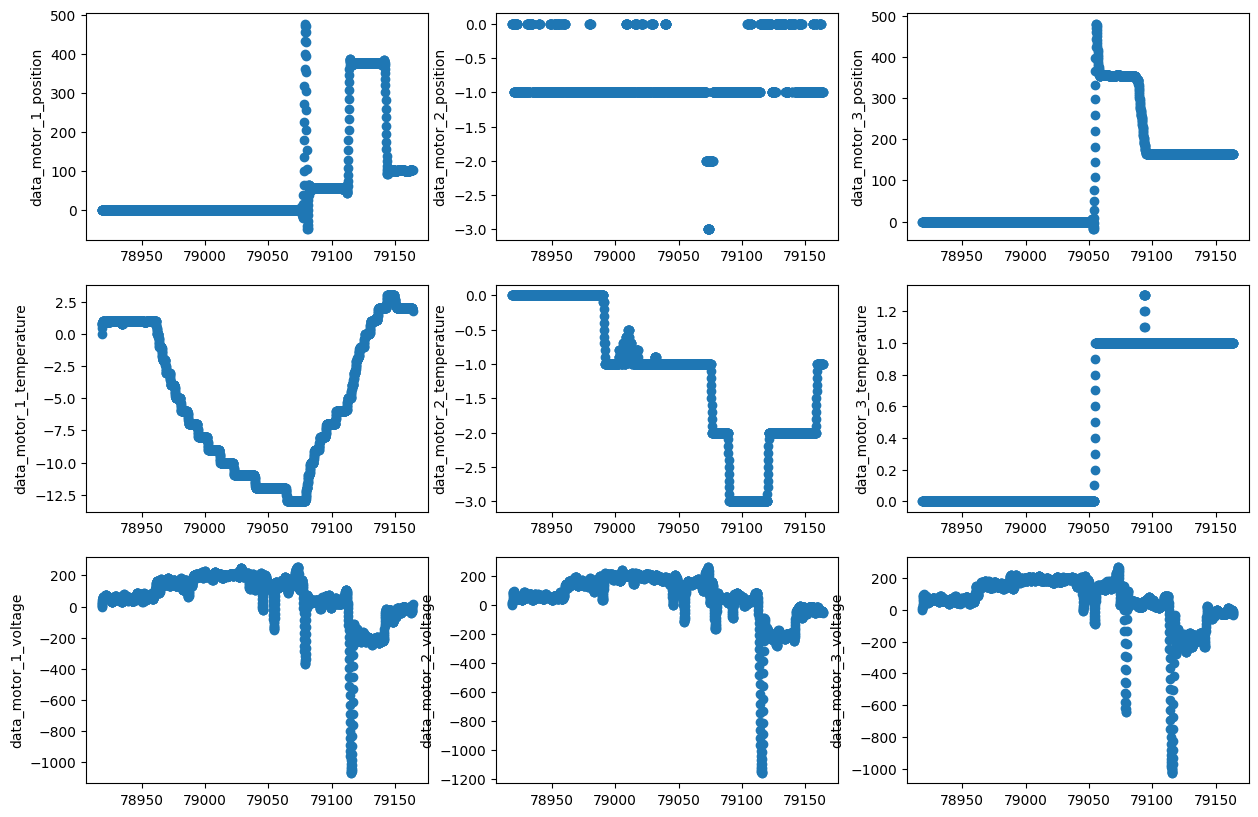

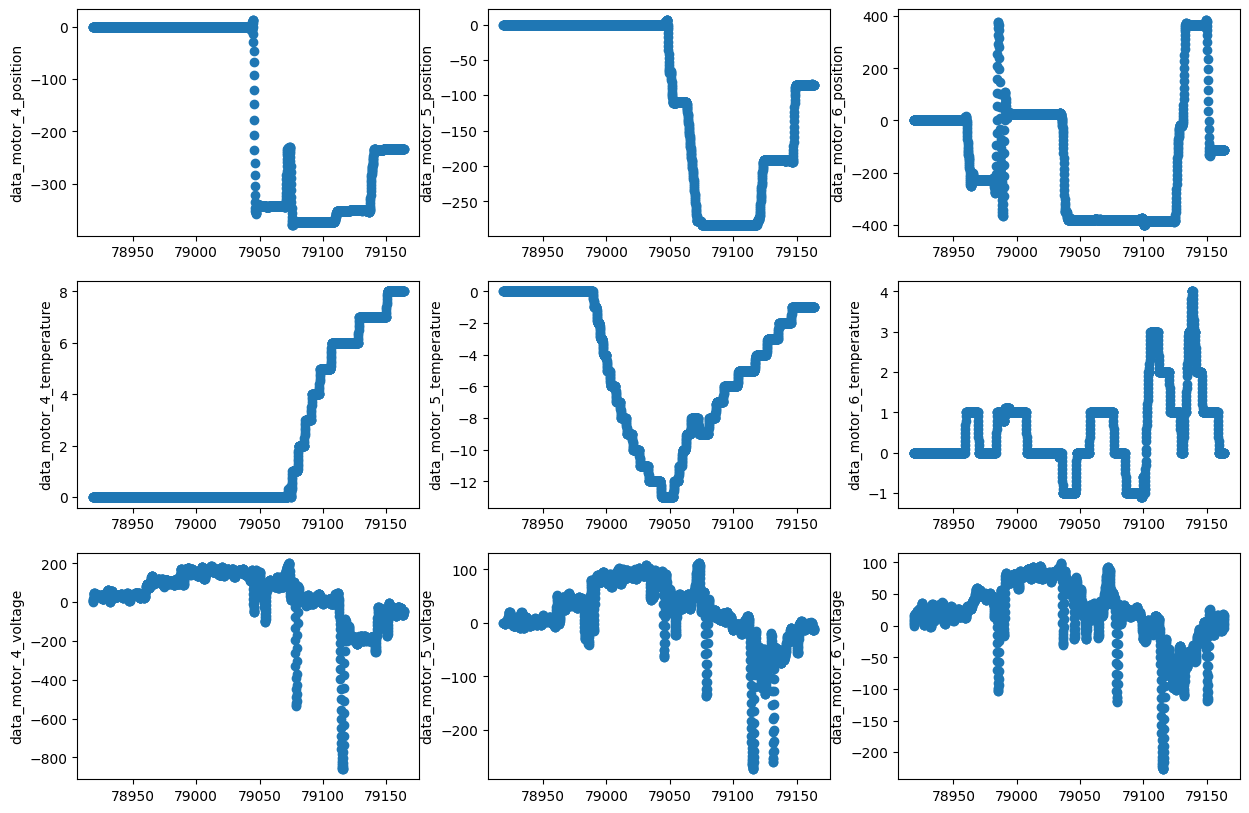

20240527_100759: 1    Transfer goods
Name: Description, dtype: object



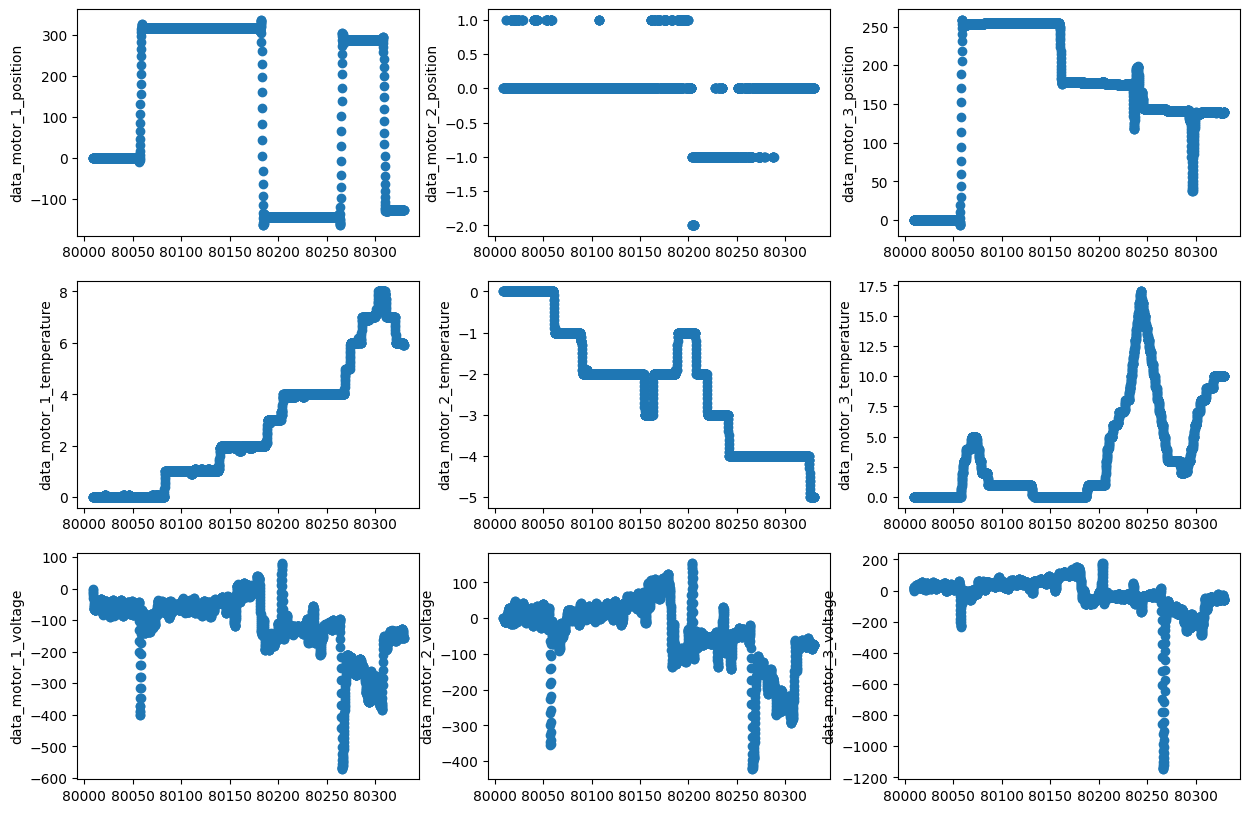

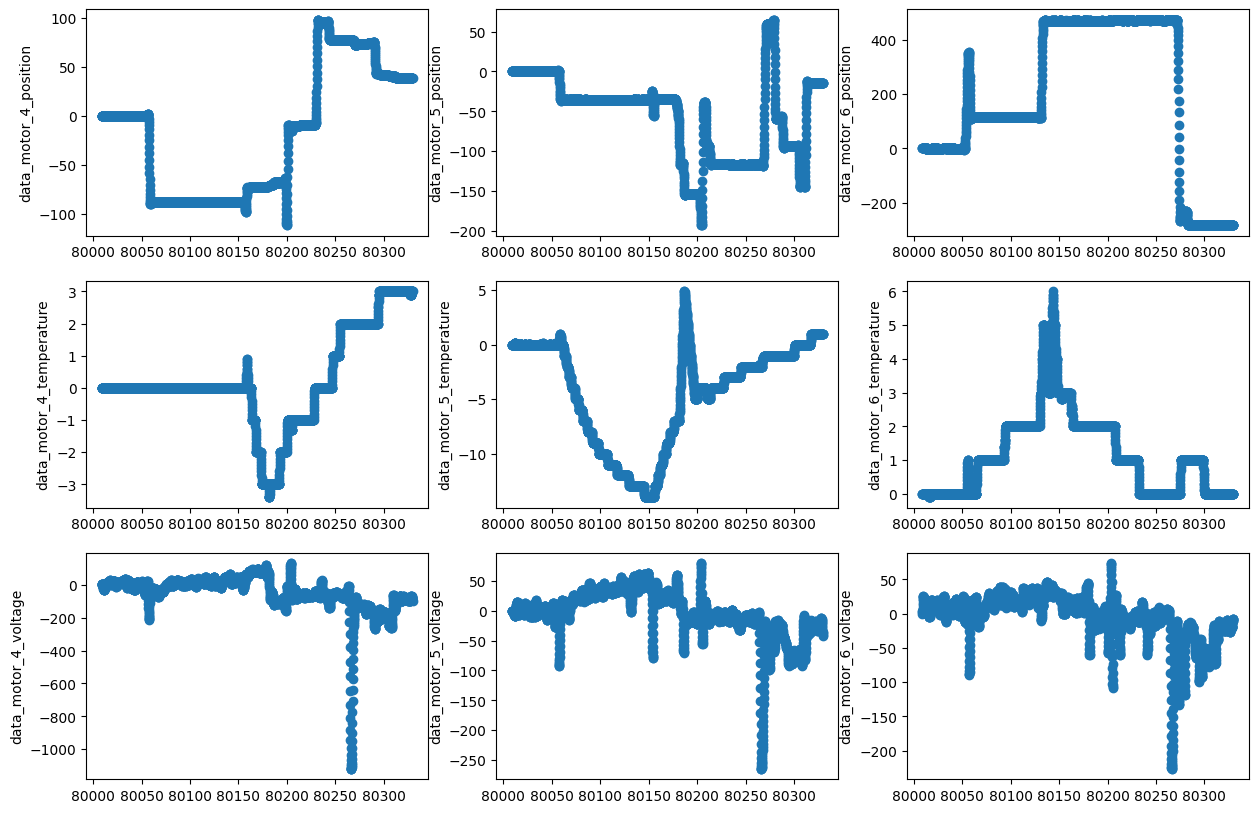

20240527_101627: 2    Transfer goods
Name: Description, dtype: object



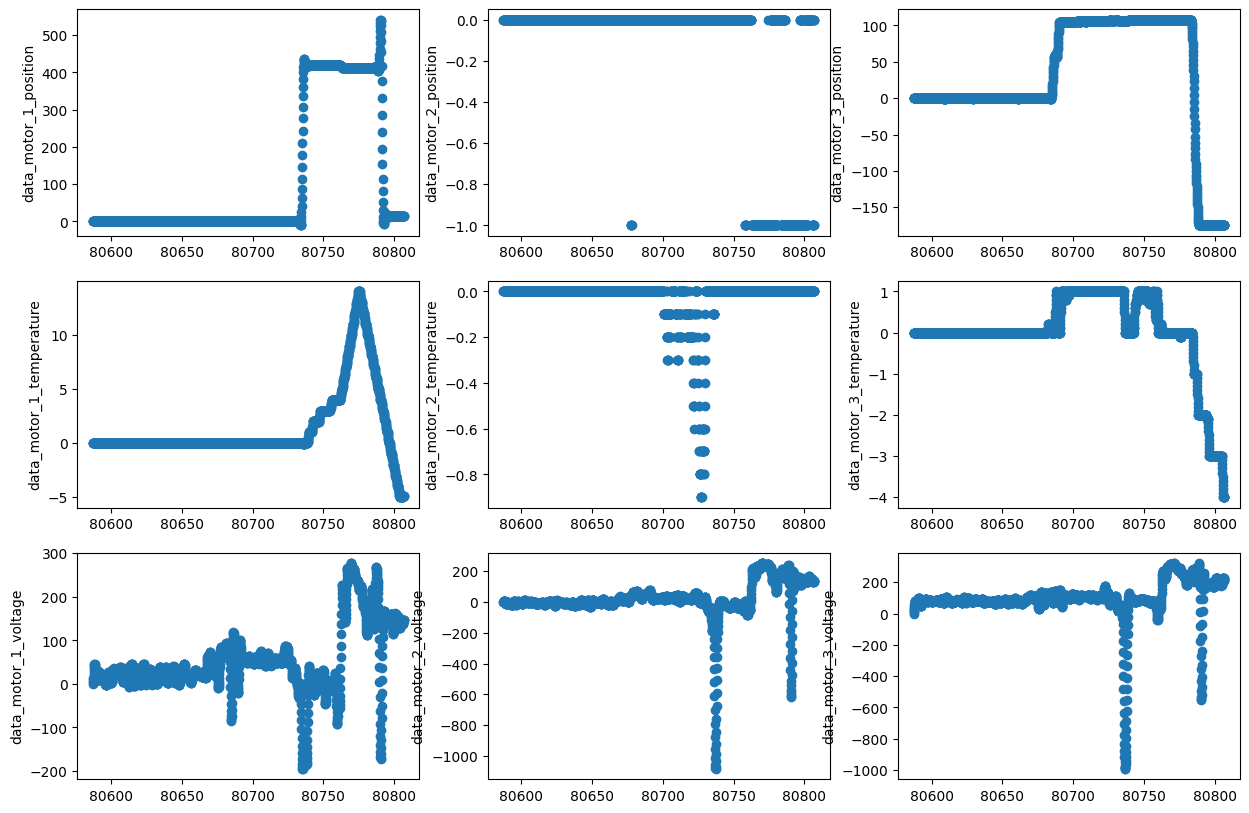

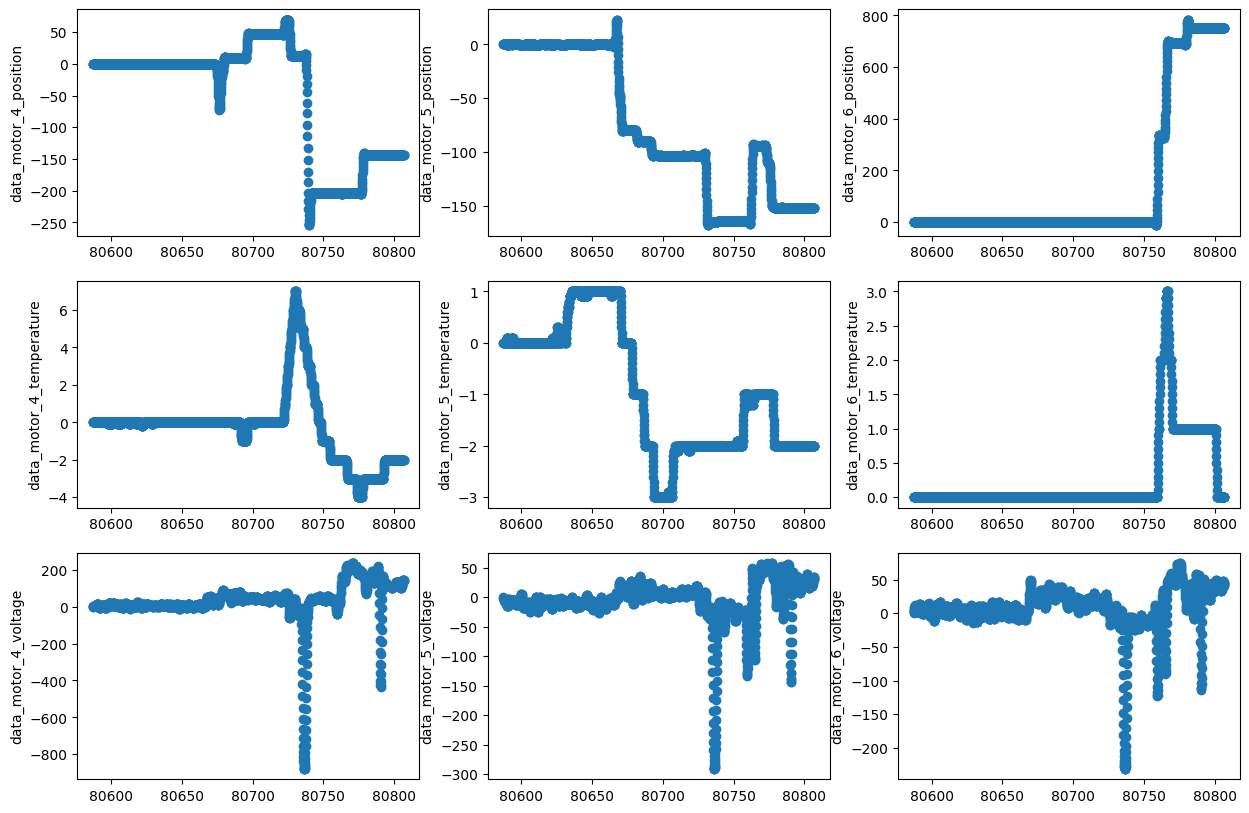

20240527_102436: 3    Not moving
Name: Description, dtype: object



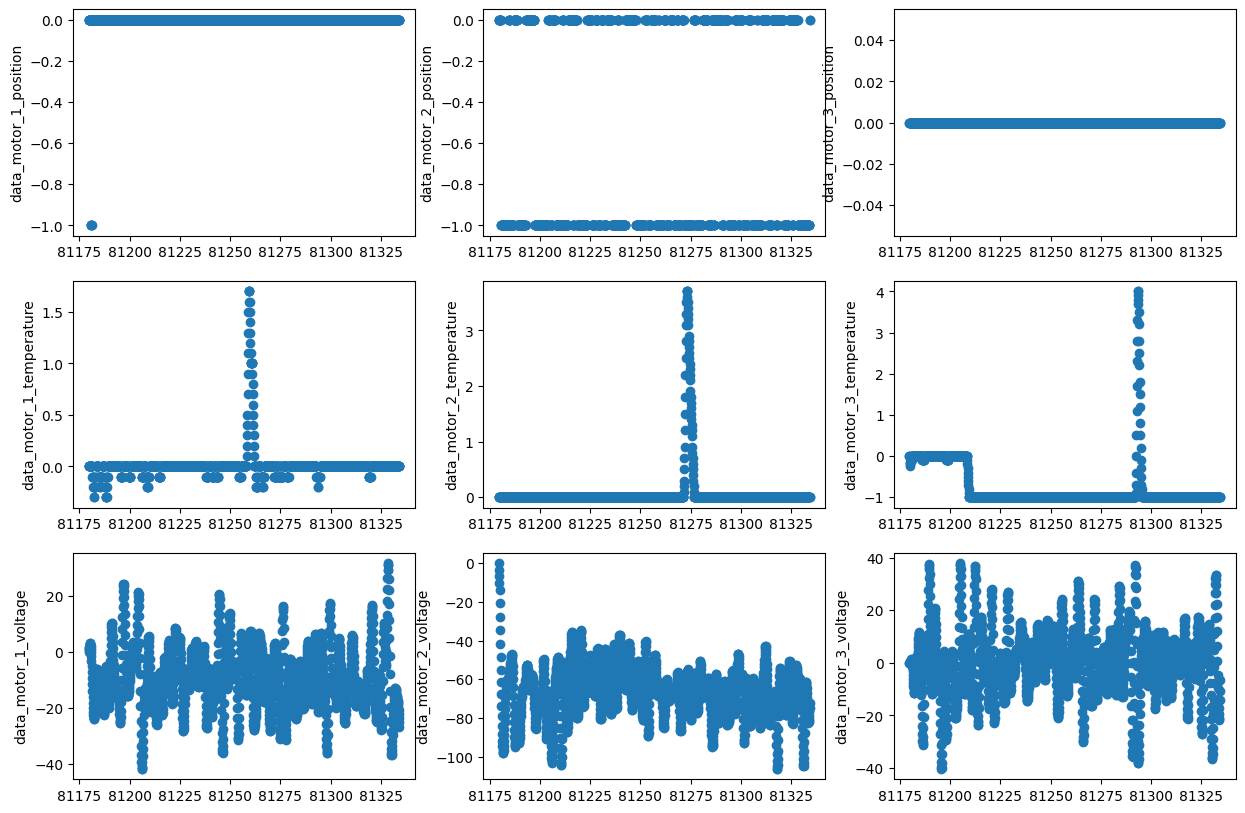

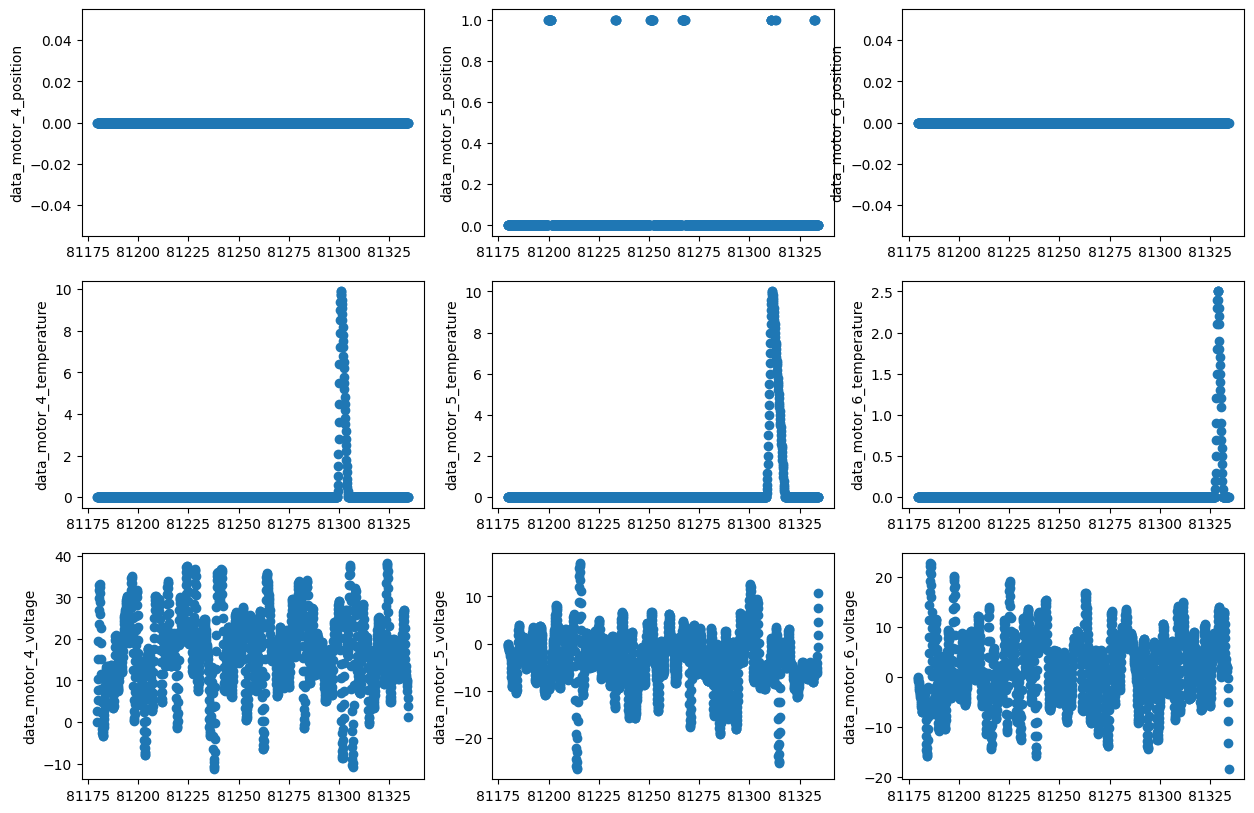

20240527_102919: 4    Not moving
Name: Description, dtype: object



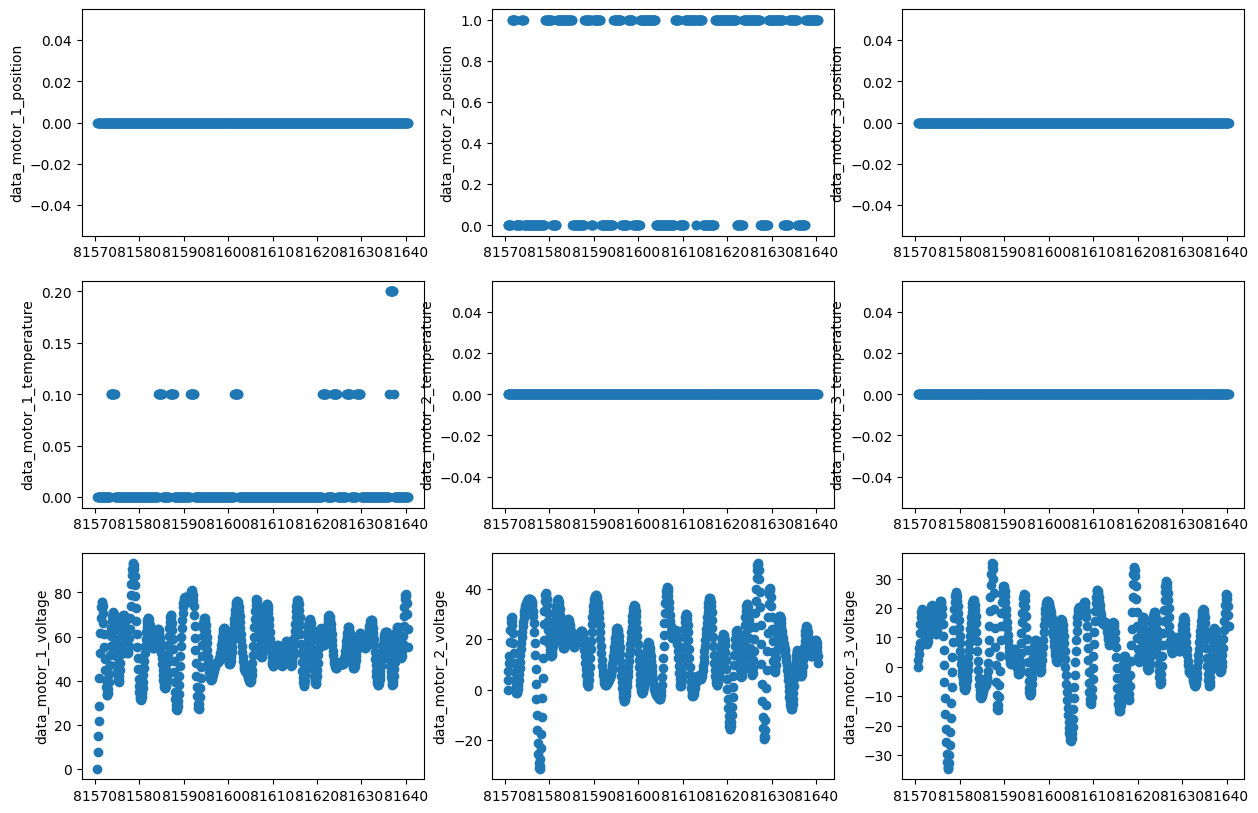

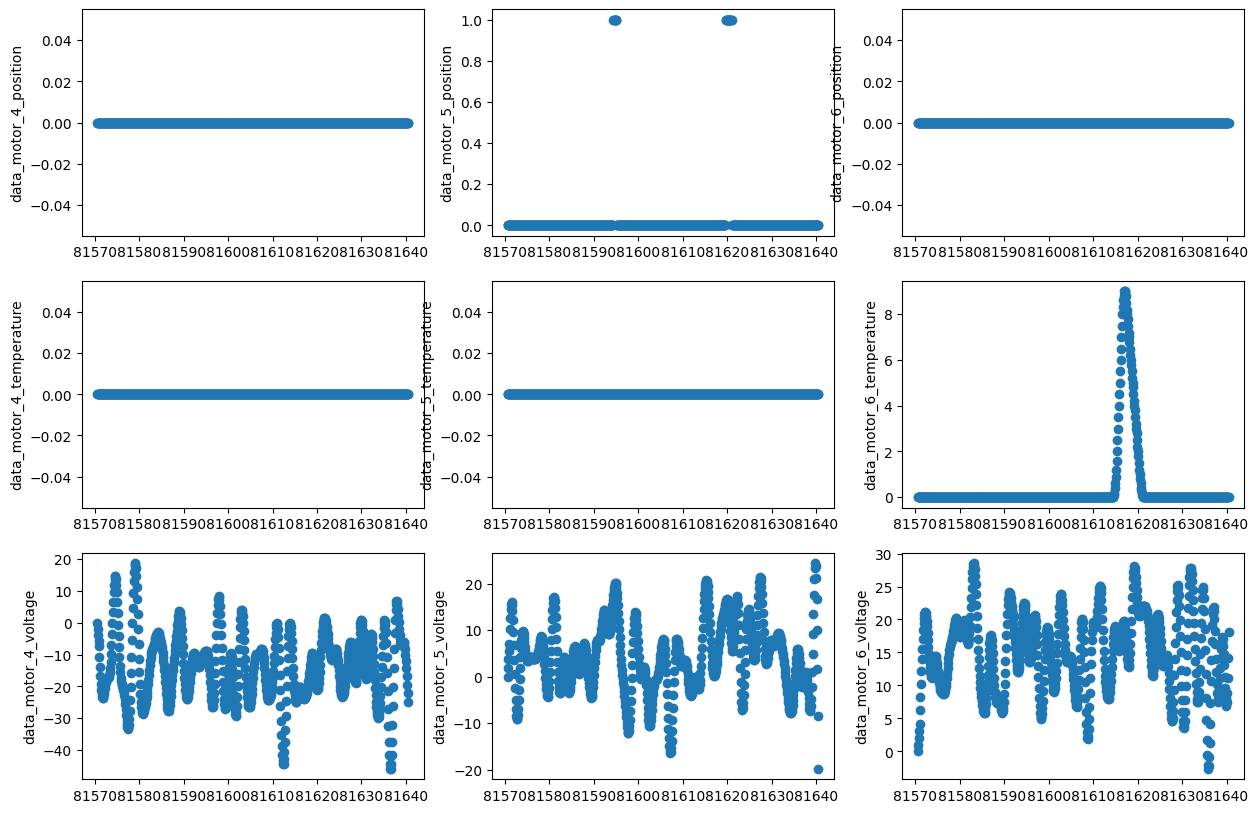

20240527_103311: 5    Not moving
Name: Description, dtype: object



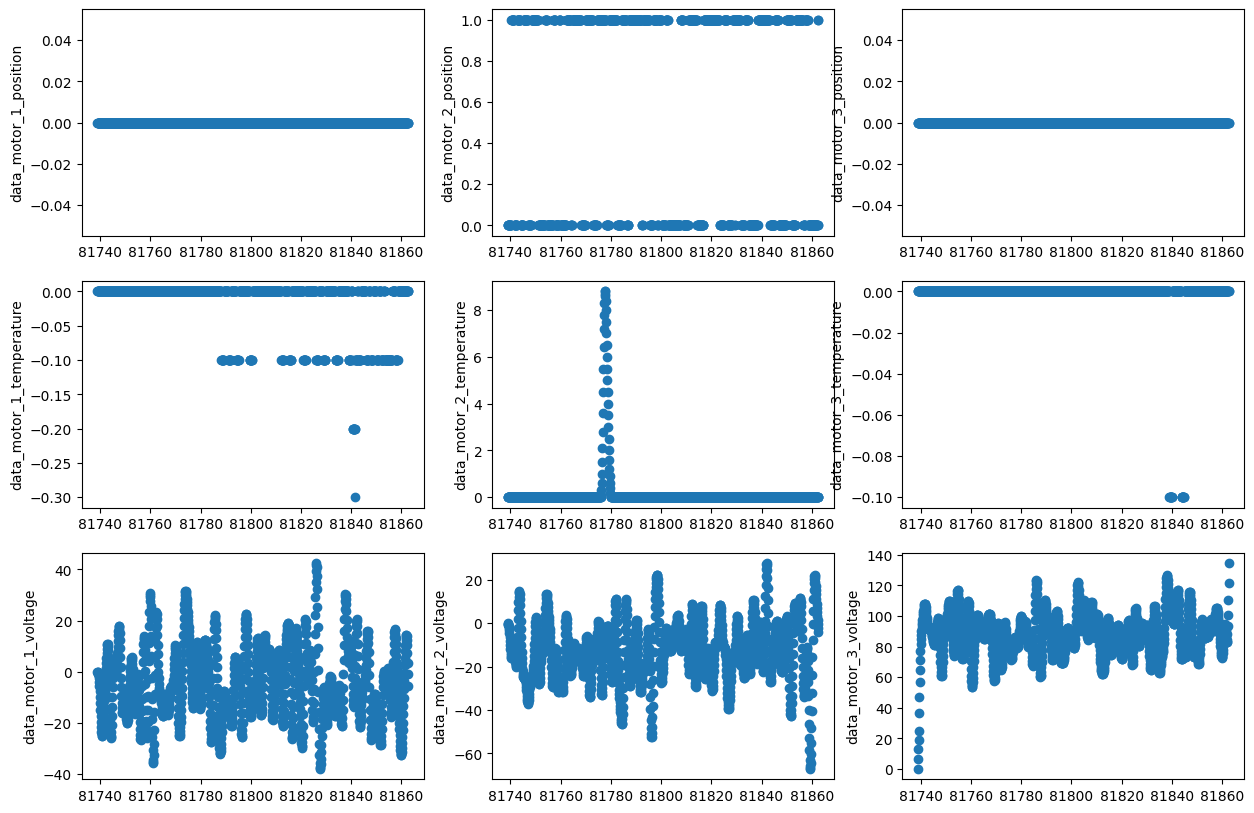

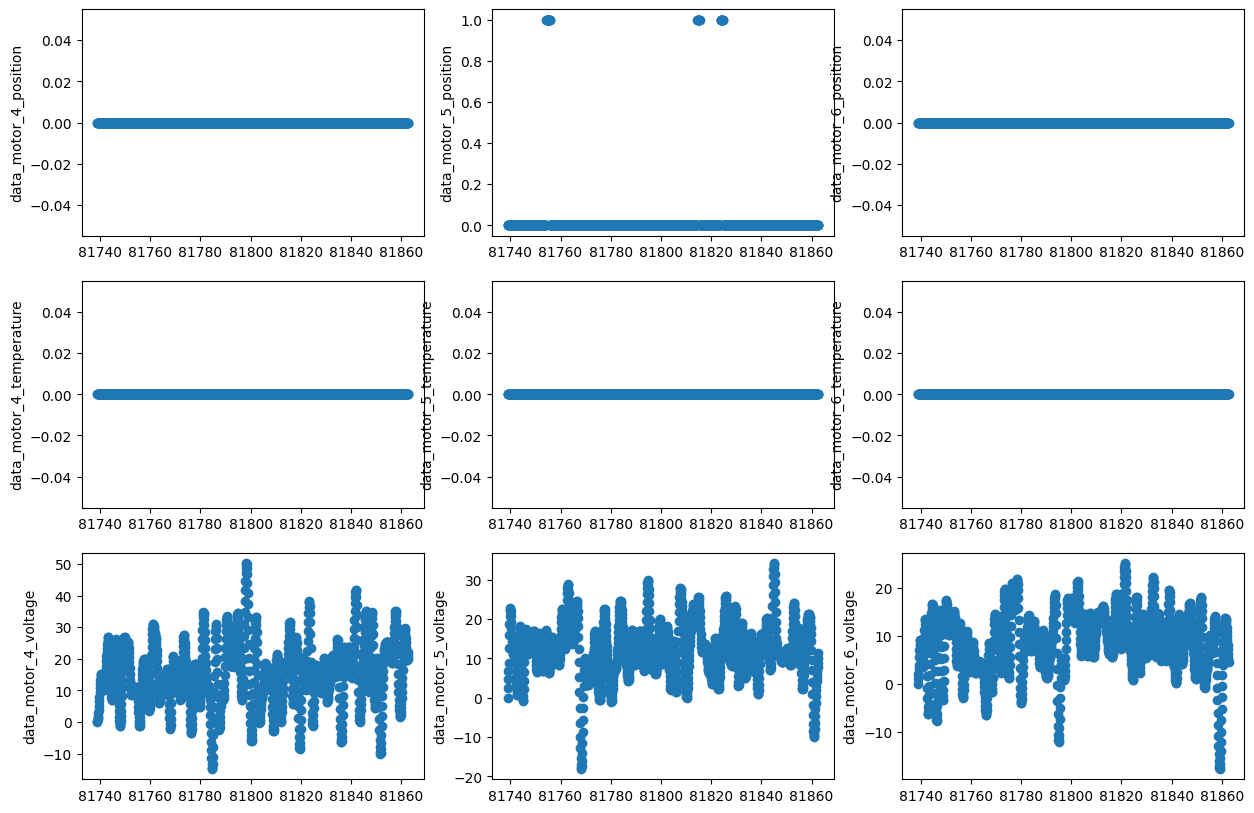

20240527_103690: 6    Moving one motor
Name: Description, dtype: object



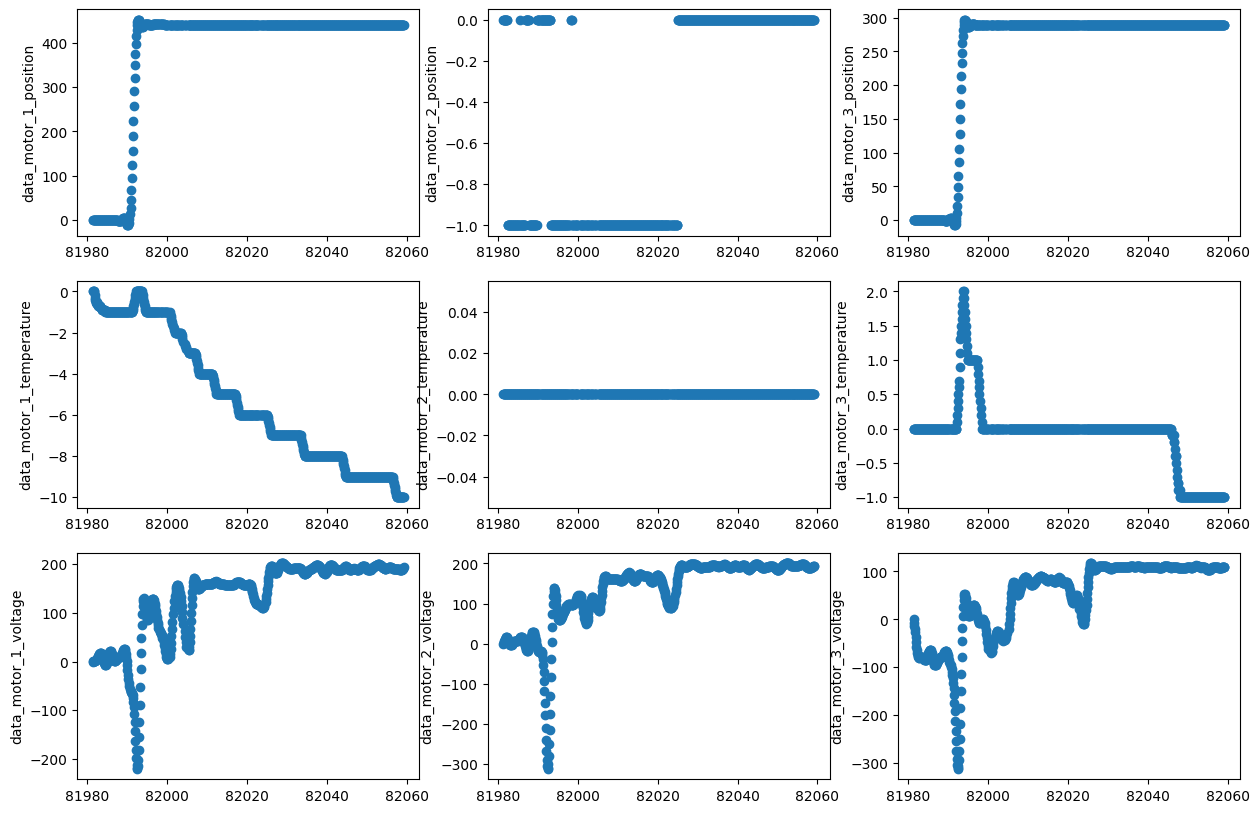

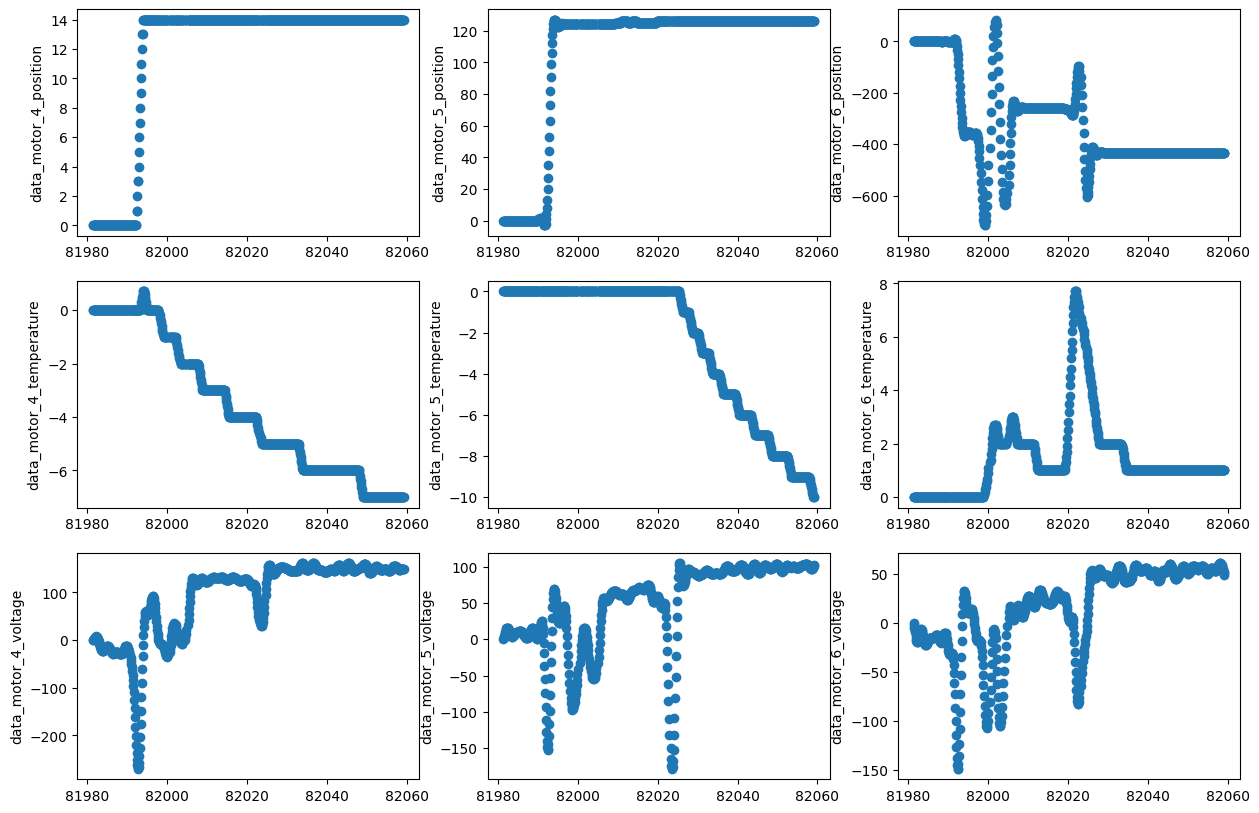

20240527_104247: 7    Moving one motor
Name: Description, dtype: object



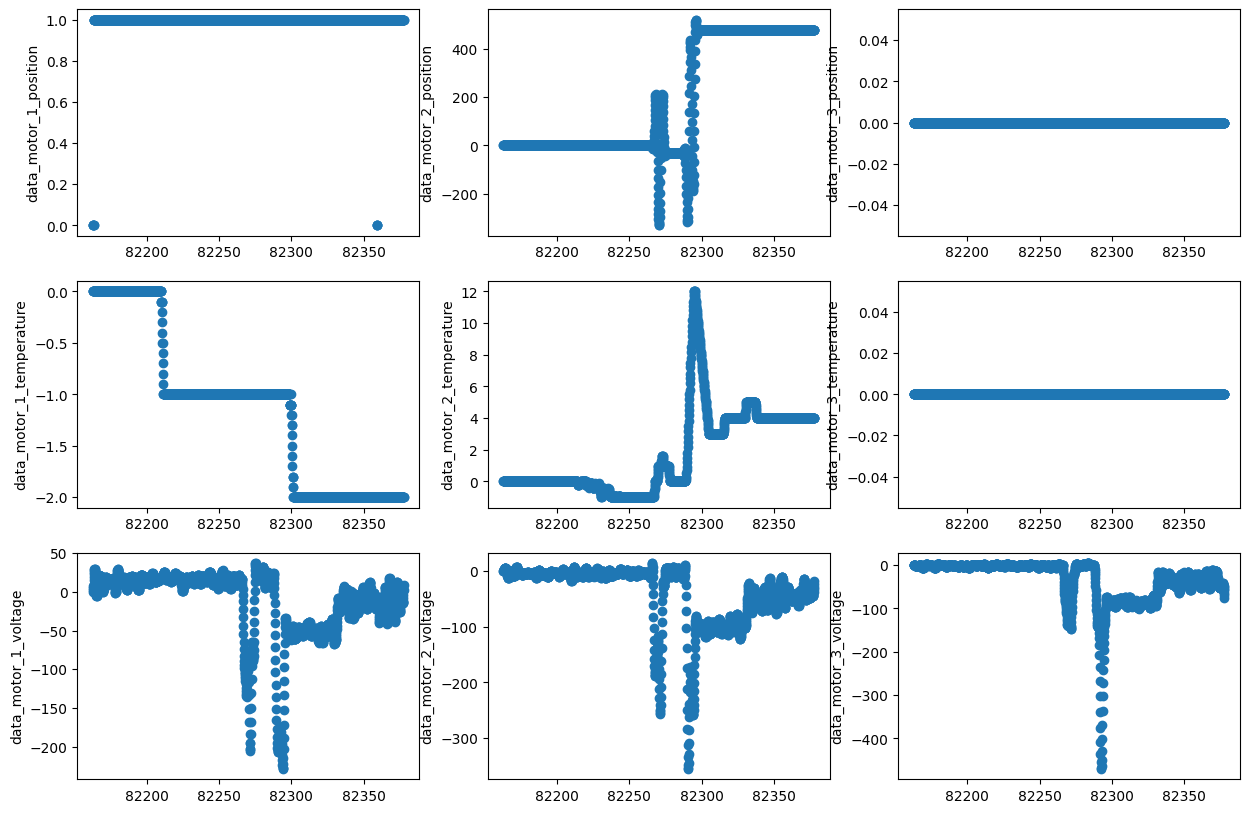

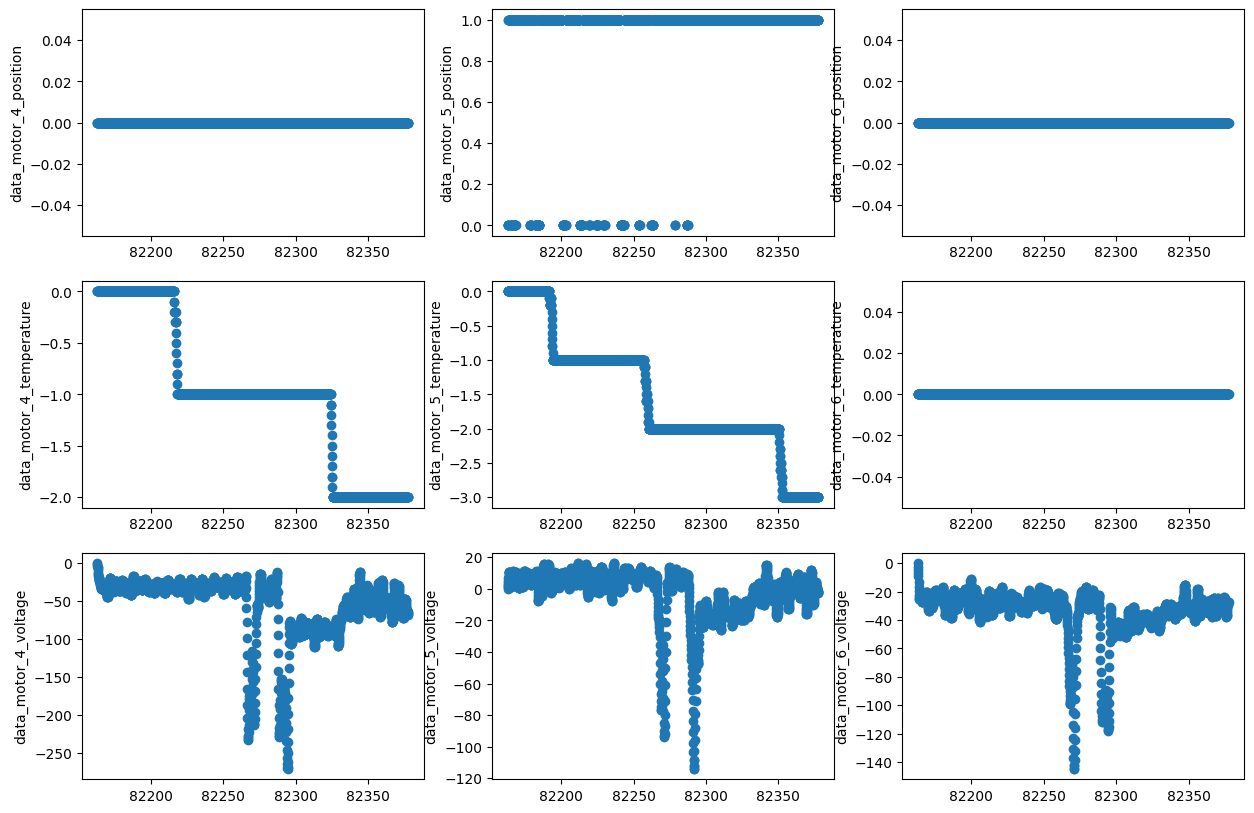

In [24]:
# Read all the dataset. Change to your dictionary if needed.
base_dictionary = '/Users/user1/Desktop/Industry_40/digital_twin_robot_group2/DataChallenge/dataset/testing_data/'
df_test = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=True)

# Motor 6

In [ ]:
from utility import extract_selected_feature, prepare_sliding_window, run_cv_one_motor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Define the motor index.
motor_idx = 6

# Specify the test conditions you would like to include in the training.
df_data_experiment = df_train[df_train['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]

# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight="balanced", n_jobs=-1))    
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid_6 = {
    'mdl__C': [0.1, 0.1, 1, 10]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search_6 = GridSearchCV(estimator=pipeline, param_grid=param_grid_6, scoring='f1', cv=5)

feature_list = ['data_motor_1_position', 'data_motor_1_temperature',
                    'data_motor_2_temperature', 'data_motor_2_position',
                    'data_motor_3_position', 'data_motor_3_temperature',
                    'data_motor_4_position', 'data_motor_4_voltage',
                    'data_motor_6_temperature']

# Train the model.
run_cv_one_motor(single_run_result=False, motor_idx=6, df_data=df_data_experiment, mdl=grid_search_6, feature_list=feature_list, n_fold=5, window_size=20, sample_step=5)

Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.156465   0.091085  0.805991  0.163673
1  0.870370   0.477551  0.609375  0.535469
2  0.578761   0.414343  0.899135  0.567273
3  0.832759   0.831889  1.000000  0.908231
4  0.672823   0.189655  0.051887  0.081481


Mean performance metric and standard error:
Accuracy: 0.6222 +- 0.2860
Precision: 0.4009 +- 0.2883
Recall: 0.6733 +- 0.3760
F1 score: 0.4512 +- 0.3350




,Accuracy,Precision,Recall,F1 score
0,0.156465,0.091085,0.805991,0.163673
1,0.870370,0.477551,0.609375,0.535469
2,0.578761,0.414343,0.899135,0.567273
3,0.832759,0.831889,1.000000,0.908231
4,0.672823,0.189655,0.051887,0.081481


In [ ]:
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list, motor_idx = 6, mdl_type='clf')

# Prepare for the testing dataset.

feature_list_test = ['data_motor_1_position', 'data_motor_1_temperature',
                    'data_motor_2_temperature', 'data_motor_2_position',
                    'data_motor_3_position', 'data_motor_3_temperature',
                    'data_motor_4_position', 'data_motor_4_voltage',
                    'data_motor_6_temperature', "test_condition"]

# Get the features.
df_test_x = df_test[feature_list_test]

grid_search_6.fit(df_tr_x, df_tr_y)

y_pred_6 = grid_search_6.predict(df_test_x)

Pipeline(steps=[('standardizer', StandardScaler()),
                ('mdl',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    n_jobs=-1))])

# Motor 5

Model for motor 5:

 New run:

training performance, accuracy is: 0.9987605354486861
training performance, precision is: 0.957983193277311
training performance, recall: 1.0
training performance, F1: 0.9785407725321889



 New run:

testing performance, accuracy is: 0.9897735573411249
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




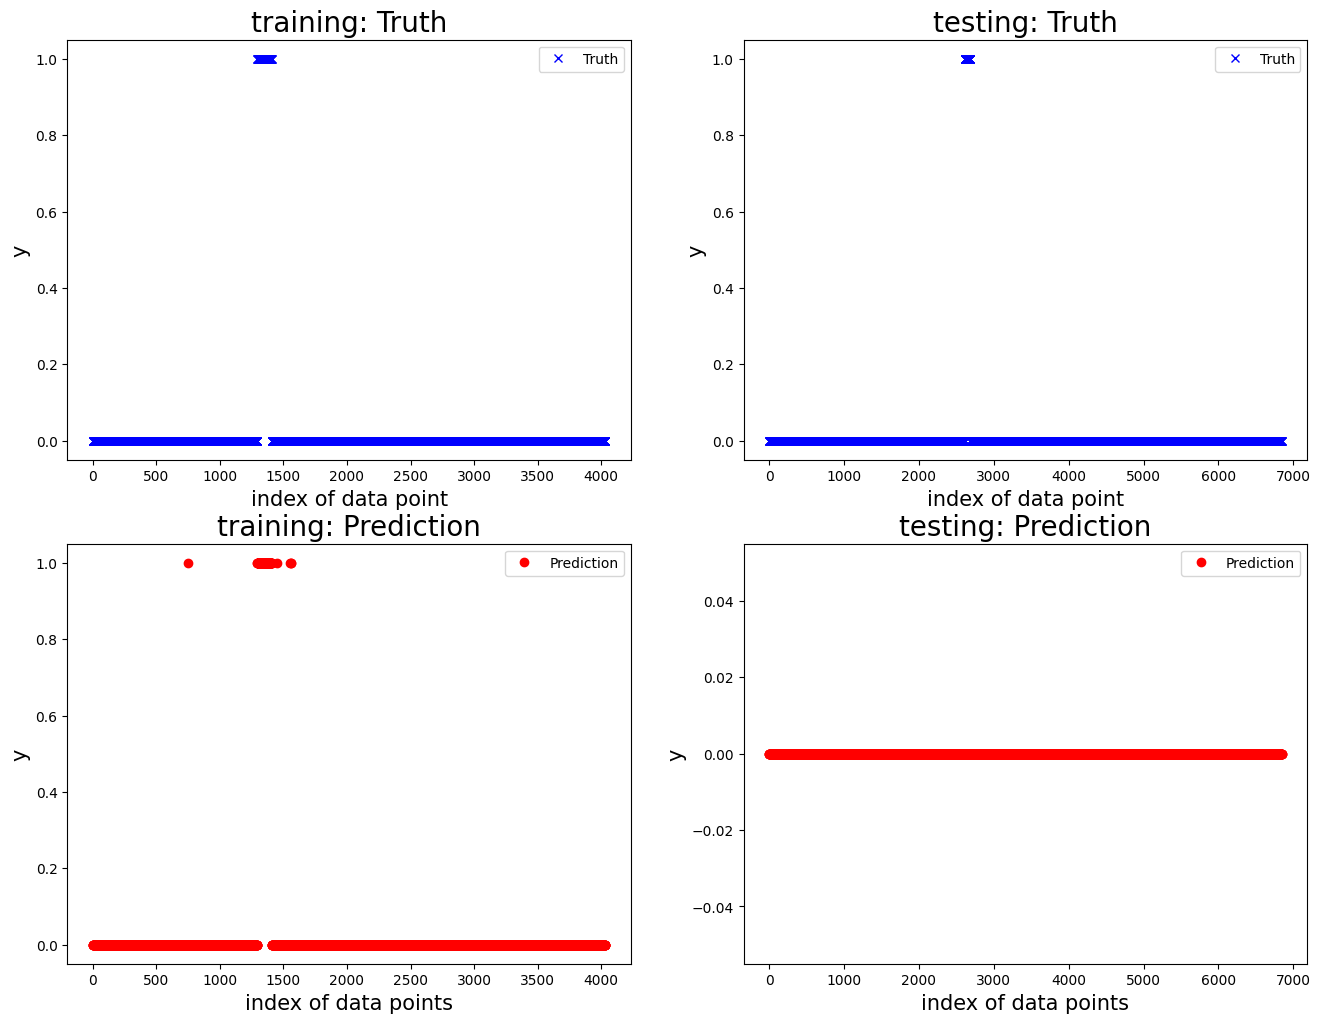


 New run:

training performance, accuracy is: 0.9872221625684527
training performance, precision is: 0.37037037037037035
training performance, recall: 1.0
training performance, F1: 0.5405405405405406



 New run:

testing performance, accuracy is: 0.9272030651340997
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




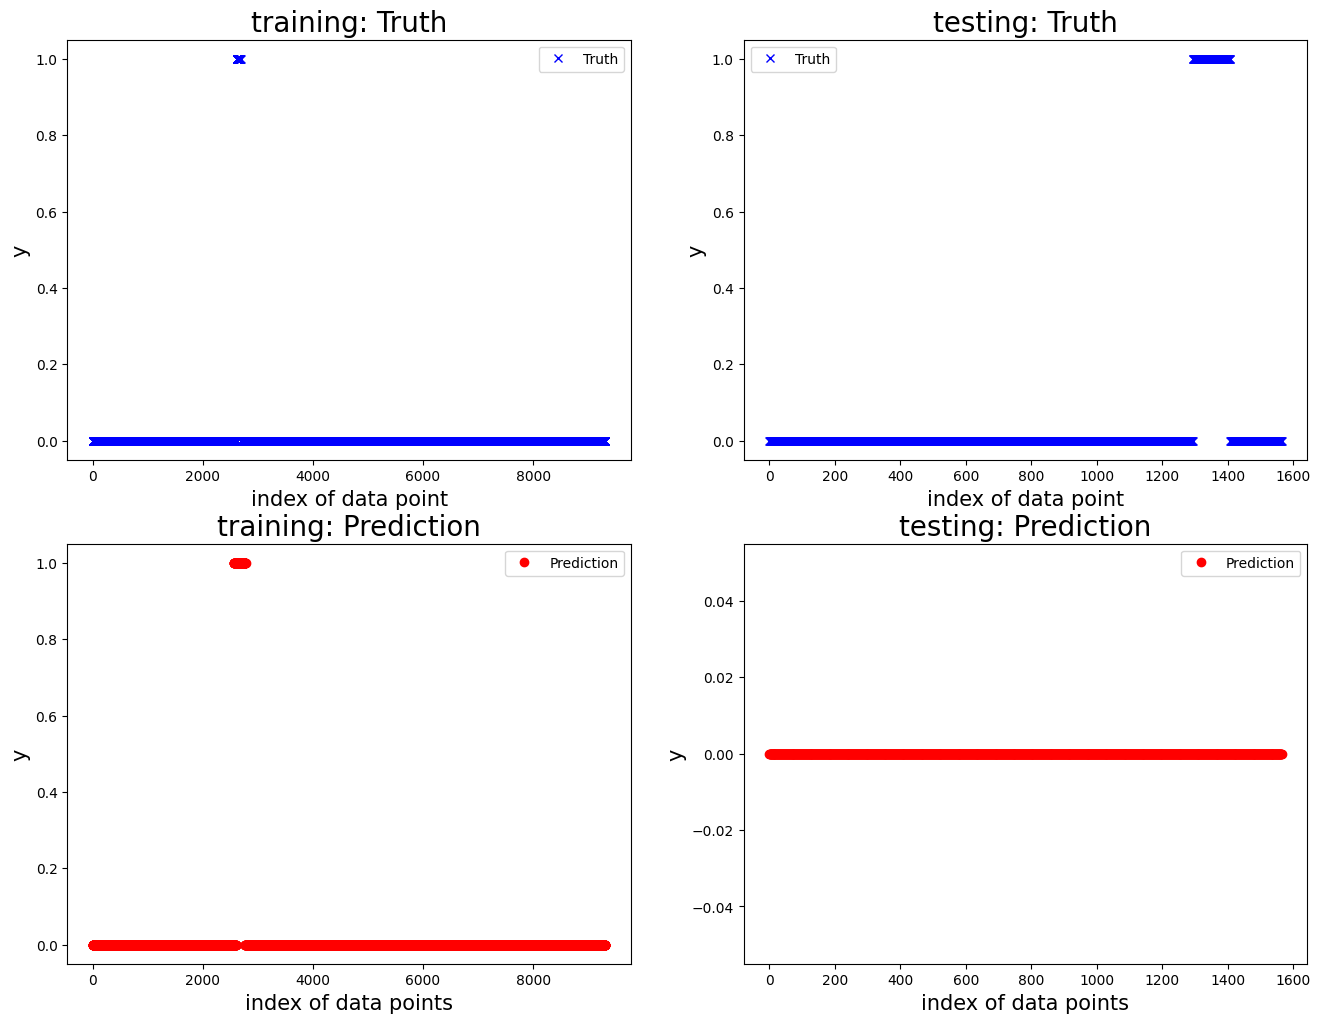


 New run:

training performance, accuracy is: 0.8952713098779362
training performance, precision is: 0.15269709543568466
training performance, recall: 1.0
training performance, F1: 0.26493880489560834



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




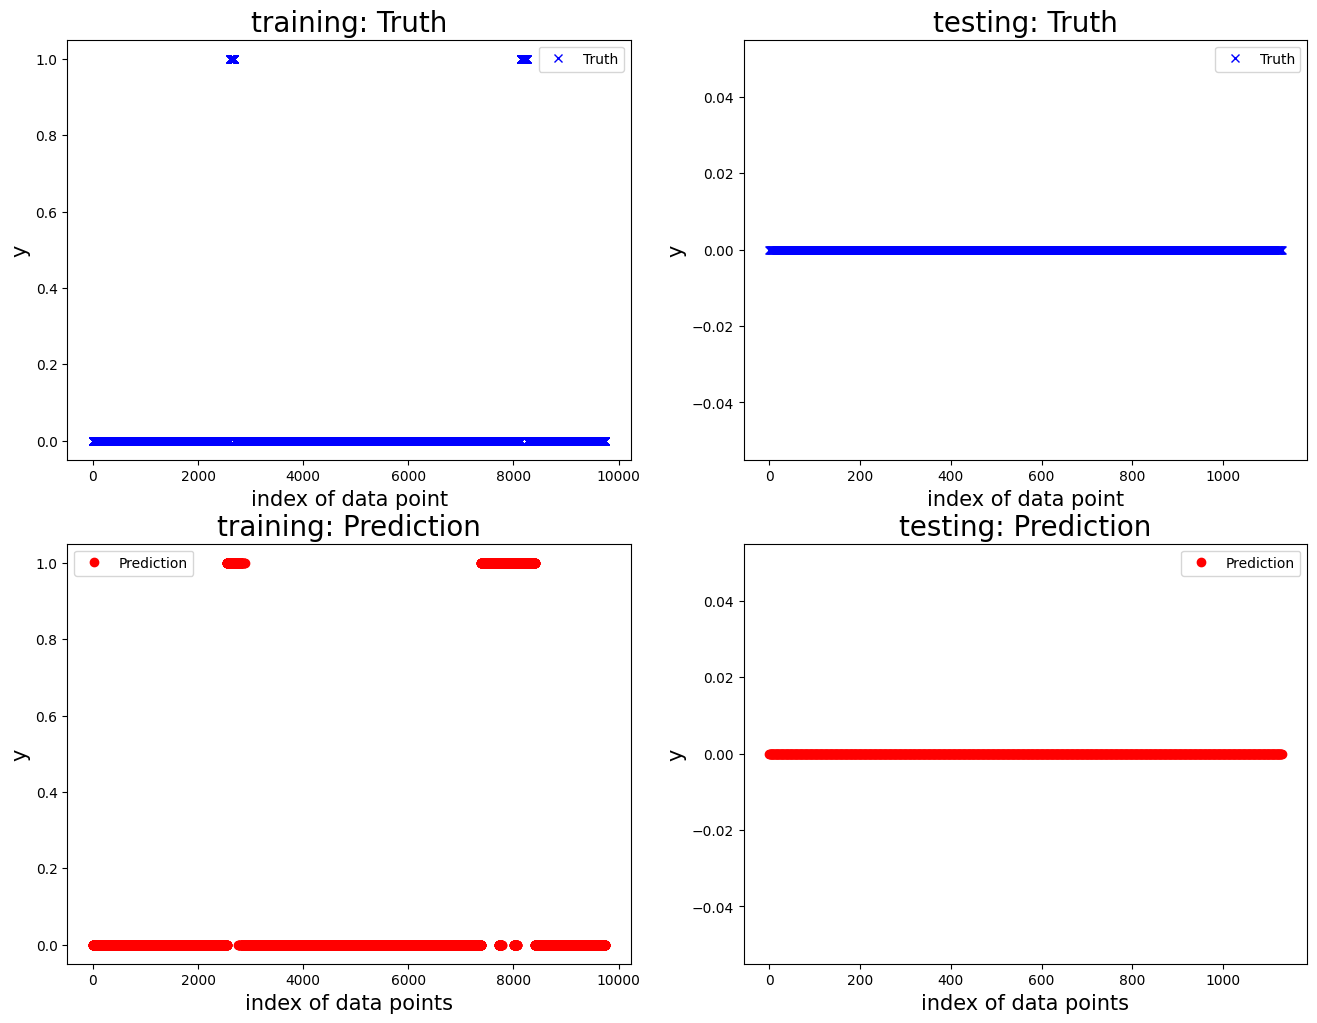


 New run:

training performance, accuracy is: 0.9273715894747063
training performance, precision is: 0.19742489270386265
training performance, recall: 1.0
training performance, F1: 0.32974910394265233



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




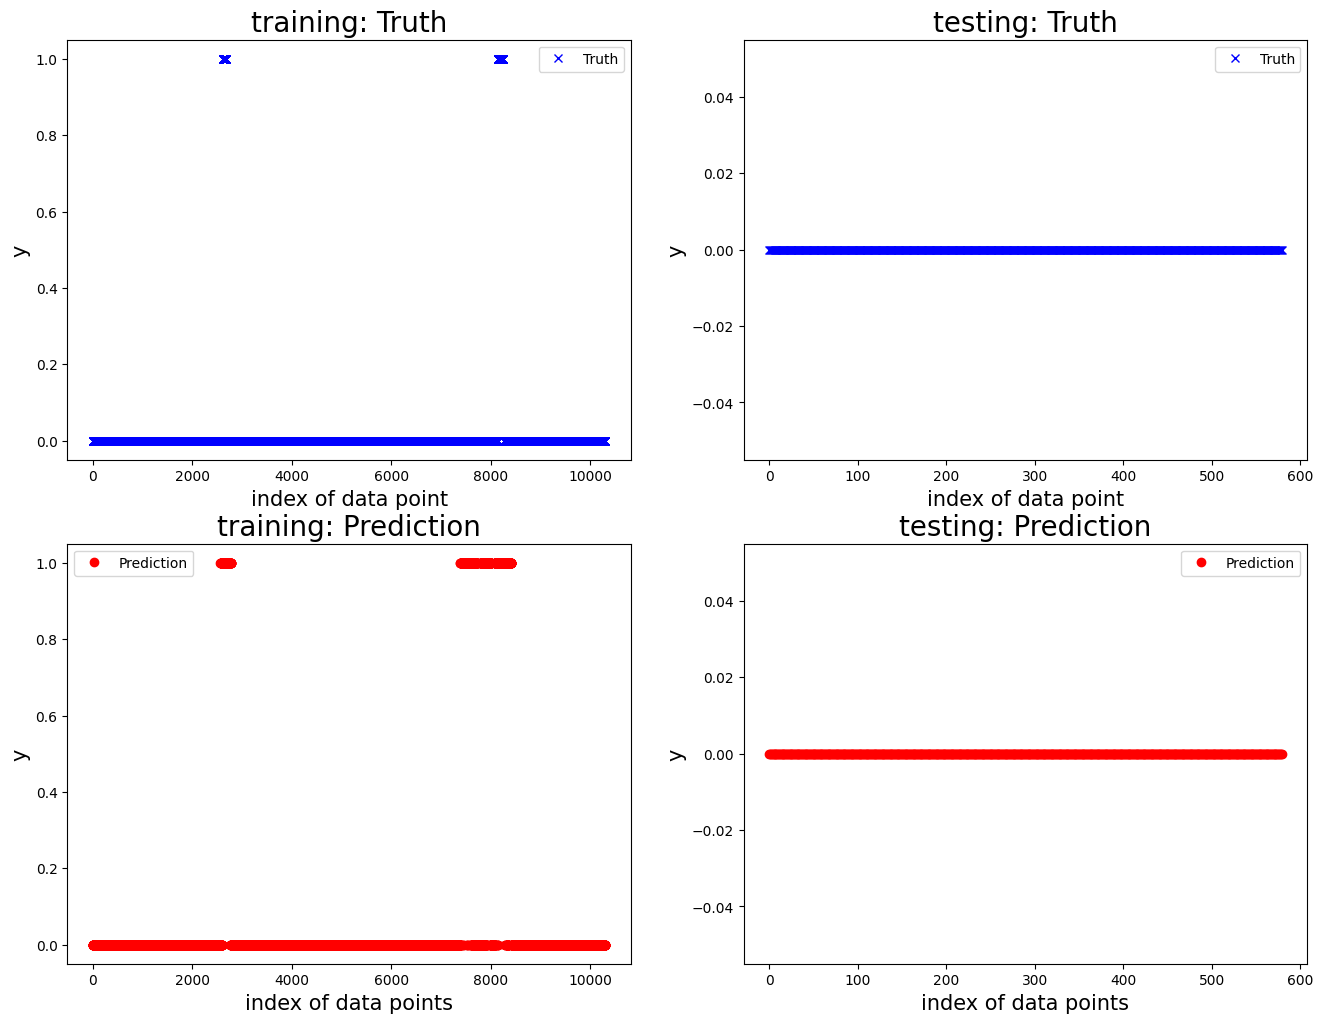


 New run:

training performance, accuracy is: 0.8978361821954353
training performance, precision is: 0.1510673234811166
training performance, recall: 1.0
training performance, F1: 0.2624821683309558



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




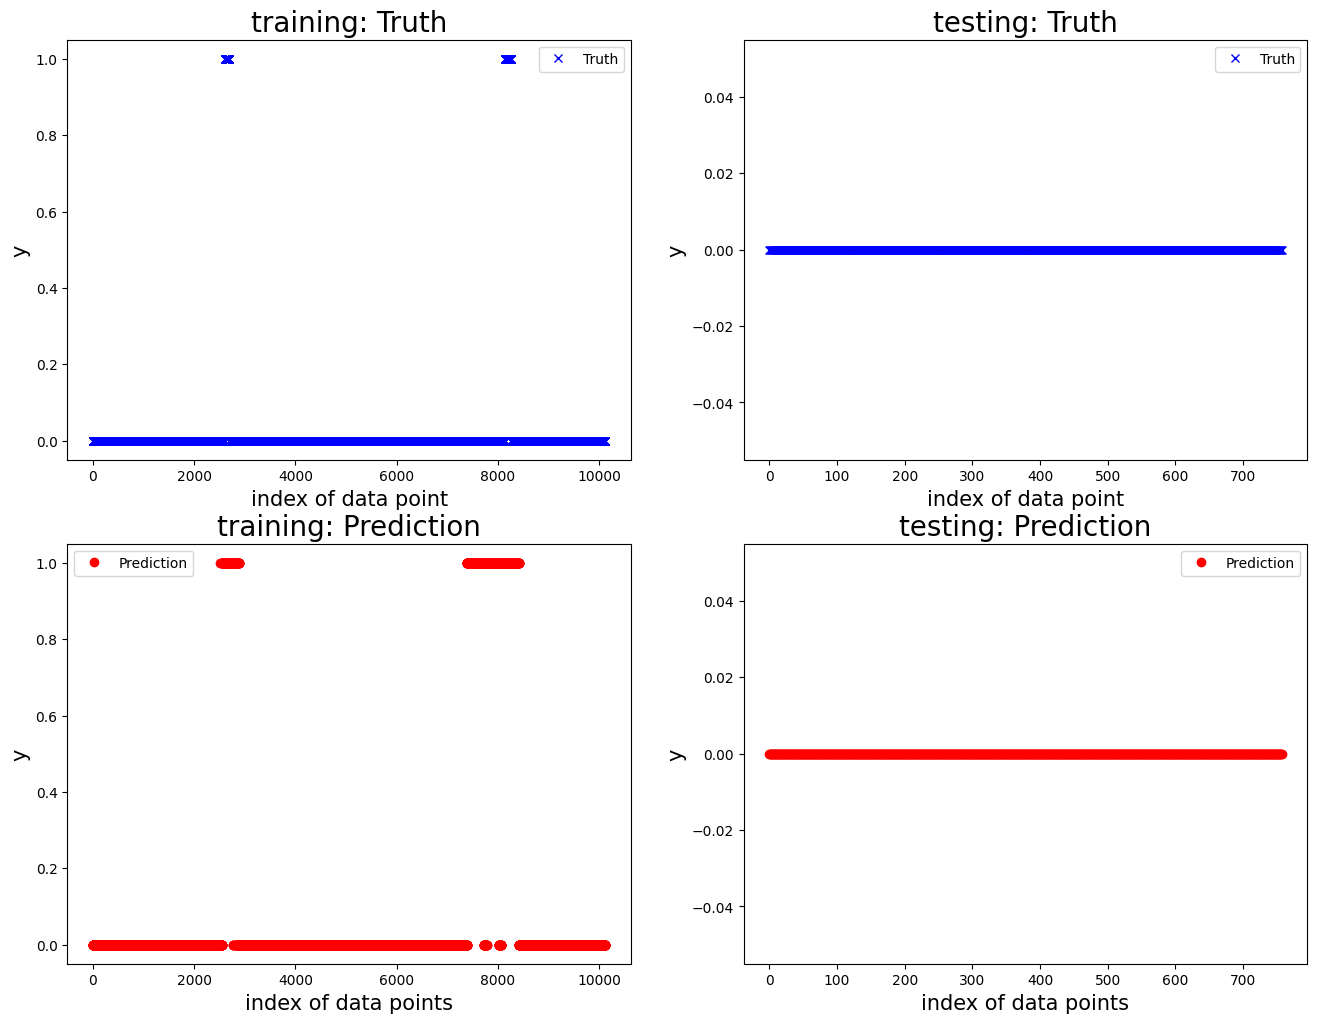

   Accuracy  Precision  Recall  F1 score
0  0.989774        0.0     0.0       0.0
1  0.927203        0.0     0.0       0.0
2  1.000000        1.0     1.0       1.0
3  1.000000        1.0     1.0       1.0
4  1.000000        1.0     1.0       1.0


Mean performance metric and standard error:
Accuracy: 0.9834 +- 0.0317
Precision: 0.6000 +- 0.5477
Recall: 0.6000 +- 0.5477
F1 score: 0.6000 +- 0.5477




,Accuracy,Precision,Recall,F1 score
0,0.989774,0.0,0.0,0.0
1,0.927203,0.0,0.0,0.0
2,1.000000,1.0,1.0,1.0
3,1.000000,1.0,1.0,1.0
4,1.000000,1.0,1.0,1.0


In [ ]:
from utility import extract_selected_feature, prepare_sliding_window, run_cv_one_motor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Define the motor index.
motor_idx = 5

# Specify the test conditions you would like to include in the training.
df_data_experiment = df_train[df_train['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]

# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', SVC(class_weight="balanced"))   
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid_5 = {
    'mdl__C': [0.1, 1, 10]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search_5 = GridSearchCV(estimator=pipeline, param_grid=param_grid_5, scoring='f1', cv=5)

feature_list = ['data_motor_1_temperature', 'data_motor_2_voltage',
                    'data_motor_5_voltage', 'data_motor_5_temperature']

# Train the model.
run_cv_one_motor(single_run_result=True, motor_idx=5, df_data=df_data_experiment, mdl=grid_search_5, feature_list=feature_list_all, n_fold=5, window_size=20, sample_step=5)

In [ ]:
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list, motor_idx = 5, mdl_type='clf')

# Prepare for the testing dataset.

feature_list_test = ['data_motor_1_temperature', 'data_motor_2_voltage',
                    'data_motor_5_voltage', 'data_motor_5_temperature', 'test_condition']

# Get the features.
df_test_x = df_test[feature_list_test]

grid_search_5.fit(df_tr_x, df_tr_y)

y_pred_5 = grid_search_5.predict(df_test_x)

## Model for motor 3.

Please copy this section for the other motors as well.

### Summary of the mode 3.

In this section, please give a brief summary of the final model you used for this motor. Important details include but not limited to:
- Which model
- What are the features you used?
- Do you tune hyperparameters? If yes, how?
- Do you consider the imbalance in the data? If yes, how?

### Training

In this section, summarize how do you train your model, and put the code here.

In [25]:
#Train files
not_moving_train = ['20240105_164214', '20240105_165972', '20240320_152031', '20240320_155664','20240325_135213', '20240425_093699', '20240425_094425', '20240426_140055']
pickup_and_place_train = ['20240105_165300', '20240321_122650', '20240325_152902','20240325_155003', '20240426_141190','20240503_163963']
moving_one_motor_train = ['20240426_141532','20240426_141602','20240426_141726','20240426_141938','20240426_141980']
turning_motor_6_train = ['20240503_164435','20240503_164675','20240503_165189' ]
moving_motors_sequentially_train = ['20240320_153841']

moving_motor_mixed_train = moving_one_motor_train + moving_motors_sequentially_train + turning_motor_6_train
#Test files
transfer_goods_test = ["20240527_094865","20240527_100759","20240527_101627"]
not_moving_test = ['20240527_102436','20240527_102919','20240527_103311']
moving_one_motor_test = ['20240527_103690','20240527_104247']


In [26]:
#Train files
not_moving_train = ['20240105_164214', '20240105_165972', '20240320_152031', '20240320_155664','20240325_135213', '20240425_093699', '20240425_094425', '20240426_140055']
pickup_and_place_train = ['20240105_165300', '20240321_122650', '20240325_152902','20240325_155003', '20240426_141190','20240503_163963']
moving_one_motor_train = ['20240426_141532','20240426_141602','20240426_141726','20240426_141938','20240426_141980']
turning_motor_6_train = ['20240503_164435','20240503_164675','20240503_165189' ]
moving_motors_sequentially_train = ['20240320_153841']

moving_motor_mixed_train = moving_one_motor_train + moving_motors_sequentially_train + turning_motor_6_train
#Test files
transfer_goods_test = ["20240527_094865","20240527_100759","20240527_101627"]
not_moving_test = ['20240527_102436','20240527_102919','20240527_103311']
moving_one_motor_test = ['20240527_103690','20240527_104247']


Model for motor 3:

 New run:

training performance, accuracy is: 0.9955578782336033
training performance, precision is: 1.0
training performance, recall: 0.06299212598425197
training performance, F1: 0.11851851851851852



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




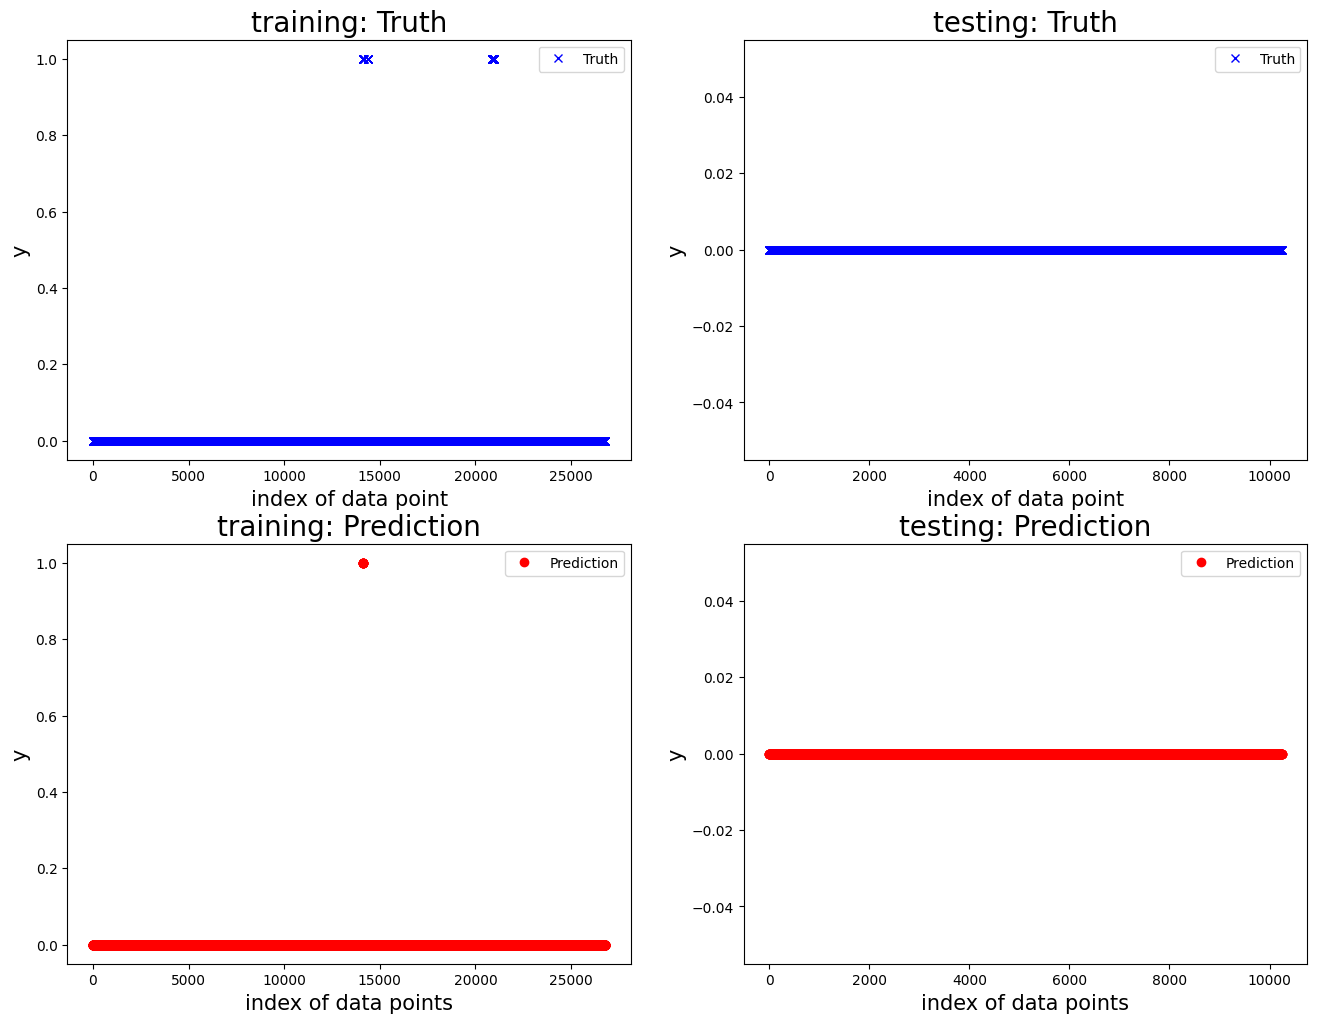


 New run:

training performance, accuracy is: 0.9951546993578517
training performance, precision is: 0.0
training performance, recall: 0.0
training performance, F1: 0.0



 New run:

testing performance, accuracy is: 0.9977891669178977
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




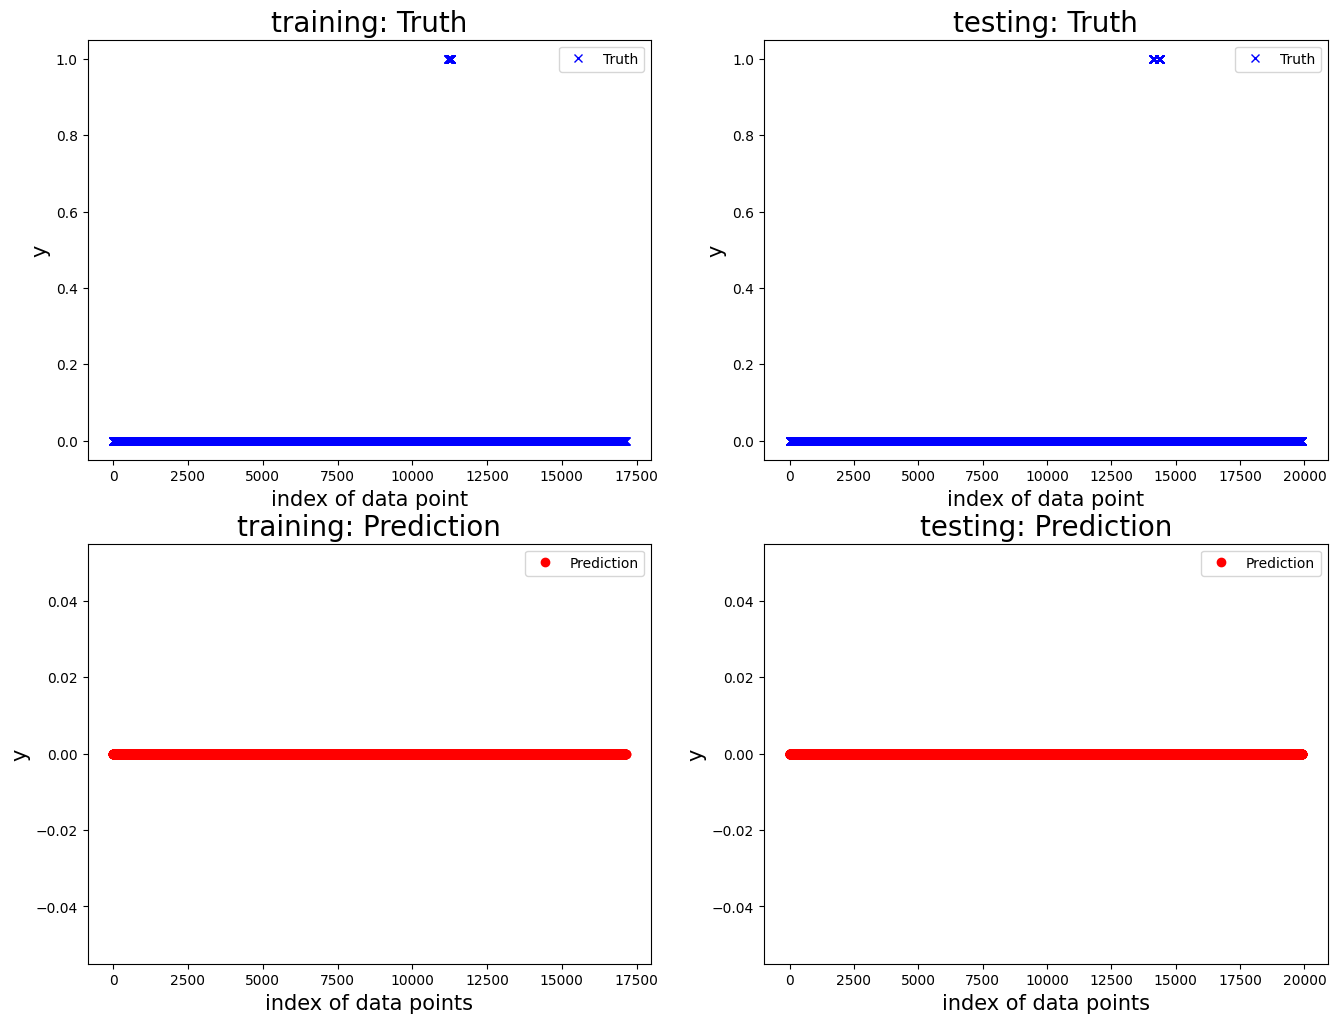


 New run:

training performance, accuracy is: 0.9992354065578591
training performance, precision is: 1.0
training performance, recall: 0.4090909090909091
training performance, F1: 0.5806451612903226



 New run:

testing performance, accuracy is: 0.9603567888999008
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




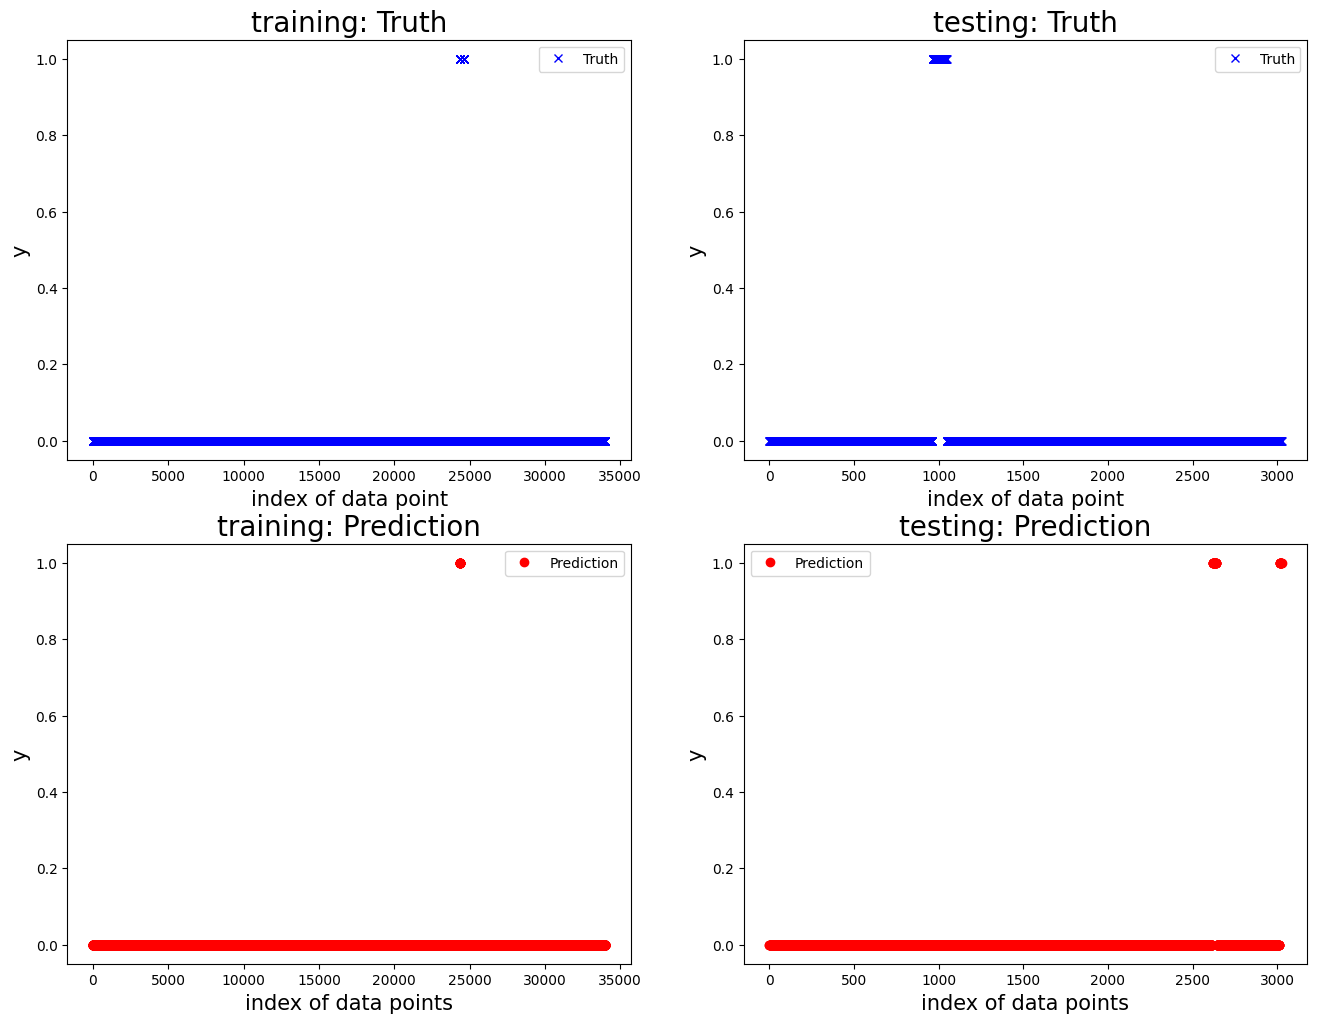


 New run:

training performance, accuracy is: 0.9967847411444142
training performance, precision is: 1.0
training performance, recall: 0.07086614173228346
training performance, F1: 0.13235294117647056



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




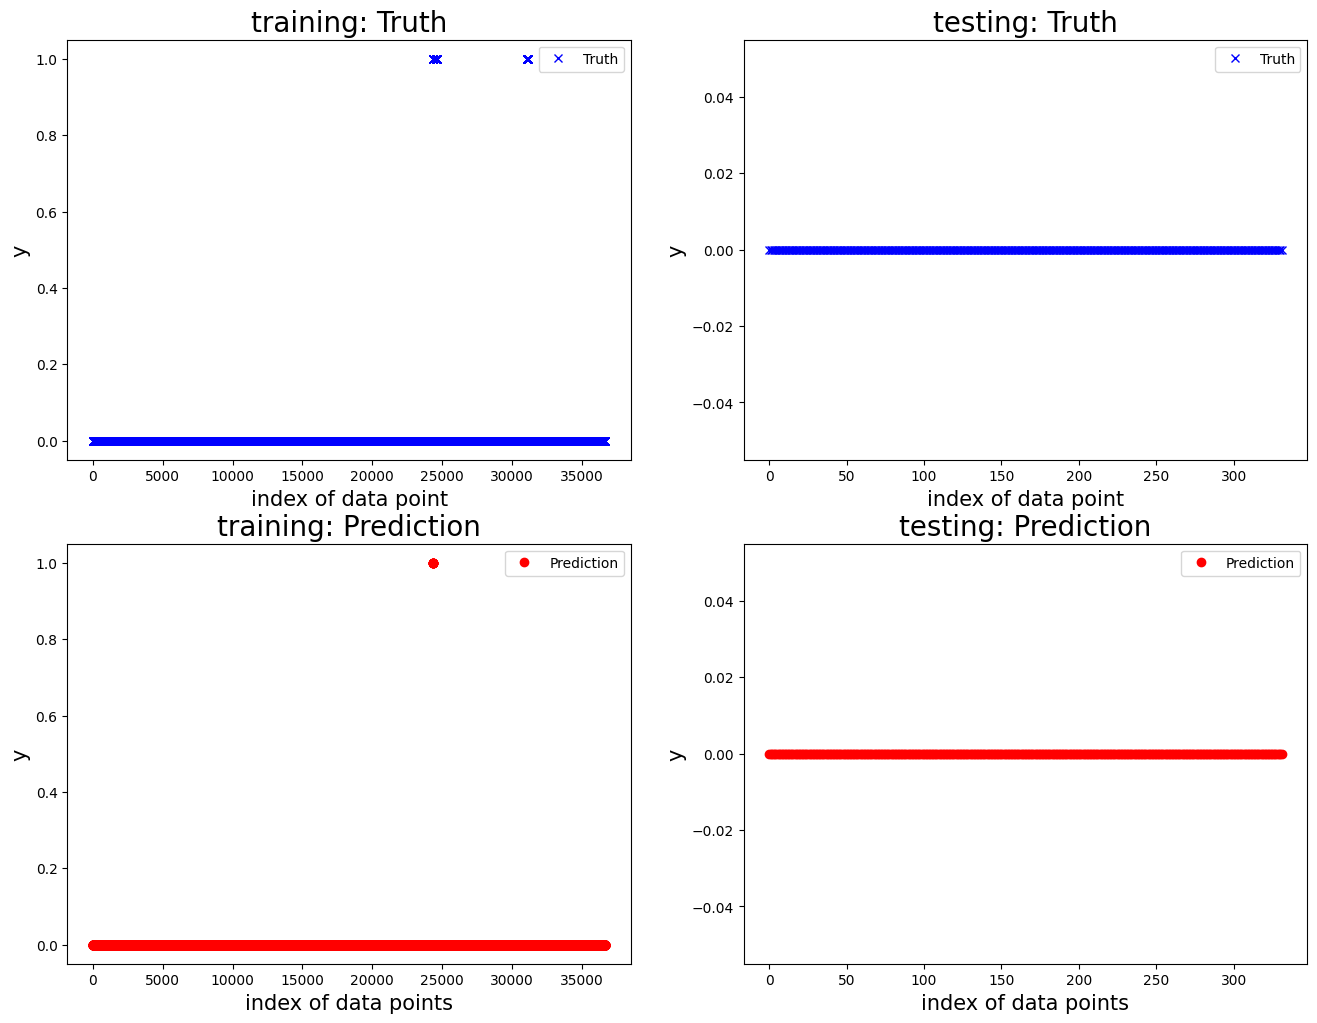


 New run:

training performance, accuracy is: 0.9965078796561605
training performance, precision is: 1.0
training performance, recall: 0.07874015748031496
training performance, F1: 0.145985401459854



 New run:

testing performance, accuracy is: 1.0
testing performance, precision is: 1.0
testing performance, recall: 1.0
testing performance, F1: 1.0




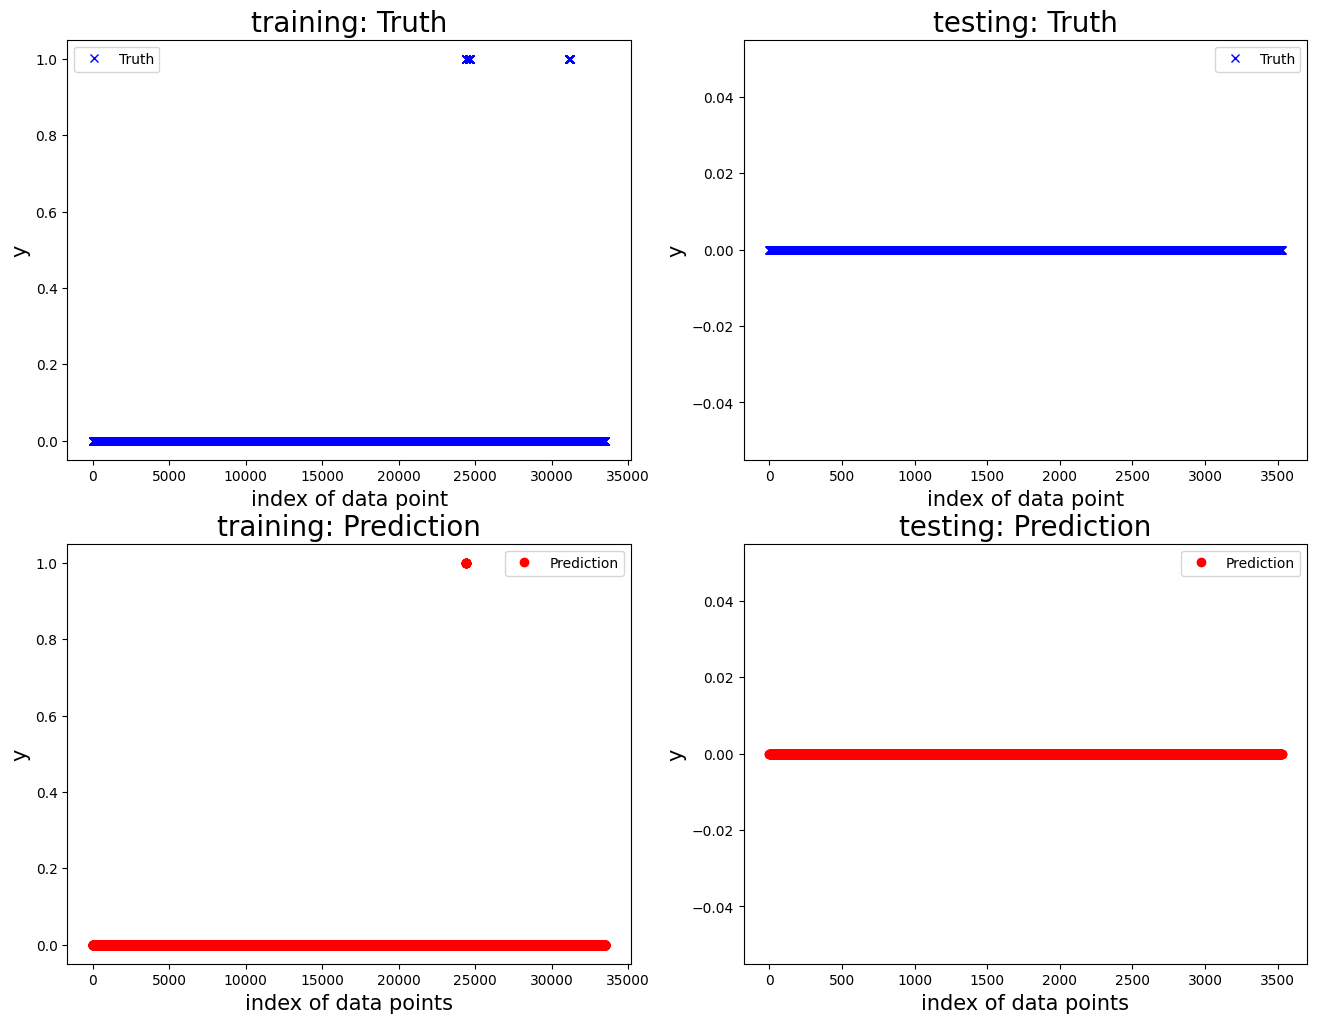

   Accuracy  Precision  Recall  F1 score
0  1.000000        1.0     1.0       1.0
1  0.997789        0.0     0.0       0.0
2  0.960357        0.0     0.0       0.0
3  1.000000        1.0     1.0       1.0
4  1.000000        1.0     1.0       1.0


Mean performance metric and standard error:
Accuracy: 0.9916 +- 0.0175
Precision: 0.6000 +- 0.5477
Recall: 0.6000 +- 0.5477
F1 score: 0.6000 +- 0.5477




In [31]:
from utility import extract_selected_feature, prepare_sliding_window, run_cv_one_motor
from sklearn.linear_model import LogisticRegression

# Define the motor index.
motor_idx = 3

# Specify the test conditions you would like to include in the training.
df_data_experiment = df_train[df_train['test_condition'].isin(not_moving_train + pickup_and_place_train + moving_motor_mixed_train)]

# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

feature_list_custom = ['data_motor_1_temperature', 'data_motor_1_position',
                       'data_motor_4_position', 'data_motor_4_position']

# Extract the features.
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_all, motor_idx, mdl_type='clf')

# Prepare the training data based on the defined sliding window.
window_size = 100
sample_step = 1
X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression() )   # Step 2: Linear Regression
]

# Create the pipeline
model = Pipeline(steps)

# # Define hyperparameters to search
# param_grid = {
#     'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)
# mdl = grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)


all_result = run_cv_one_motor(single_run_result=True, motor_idx=motor_idx,  window_size=window_size, sample_step=sample_step,
                              df_data=df_data_experiment, mdl=model, 
                              feature_list=feature_list_custom, n_fold=5)
# Train the model.
# mdl = grid_search.fit(X_train, y_train)

## Model for motor 4.

Please copy this section for the other motors as well.

### Summary of the mode 4.

In this section, please give a brief summary of the final model you used for this motor. Important details include but not limited to:
- Which model
- What are the features you used?
- Do you tune hyperparameters? If yes, how?
- Do you consider the imbalance in the data? If yes, how?

### Training

In this section, summarize how do you train your model, and put the code here.

In [ ]:
#Train files
not_moving_train = ['20240105_164214', '20240105_165972', '20240320_152031', '20240320_155664','20240325_135213', '20240425_093699', '20240425_094425', '20240426_140055']
pickup_and_place_train = ['20240105_165300', '20240321_122650', '20240325_152902','20240325_155003', '20240426_141190','20240503_163963']
moving_one_motor_train = ['20240426_141532','20240426_141602','20240426_141726','20240426_141938','20240426_141980']
turning_motor_6_train = ['20240503_164435','20240503_164675','20240503_165189' ]
moving_motors_sequentially_train = ['20240320_153841']

moving_motor_mixed_train = moving_one_motor_train + moving_motors_sequentially_train + turning_motor_6_train
#Test files
transfer_goods_test = ["20240527_094865","20240527_100759","20240527_101627"]
not_moving_test = ['20240527_102436','20240527_102919','20240527_103311']
moving_one_motor_test = ['20240527_103690','20240527_104247']


In [ ]:
#Train files
not_moving_train = ['20240105_164214', '20240105_165972', '20240320_152031', '20240320_155664','20240325_135213', '20240425_093699', '20240425_094425', '20240426_140055']
pickup_and_place_train = ['20240105_165300', '20240321_122650', '20240325_152902','20240325_155003', '20240426_141190','20240503_163963']
moving_one_motor_train = ['20240426_141532','20240426_141602','20240426_141726','20240426_141938','20240426_141980']
turning_motor_6_train = ['20240503_164435','20240503_164675','20240503_165189' ]
moving_motors_sequentially_train = ['20240320_153841']

moving_motor_mixed_train = moving_one_motor_train + moving_motors_sequentially_train + turning_motor_6_train
#Test files
transfer_goods_test = ["20240527_094865","20240527_100759","20240527_101627"]
not_moving_test = ['20240527_102436','20240527_102919','20240527_103311']
moving_one_motor_test = ['20240527_103690','20240527_104247']


Model for motor 4:

 New run:

training performance, accuracy is: 0.9921982903430513
training performance, precision is: 0.997524369487854
training performance, recall: 0.970933734939759
training performance, F1: 0.9840494543234375



 New run:

testing performance, accuracy is: 0.995411500536952
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




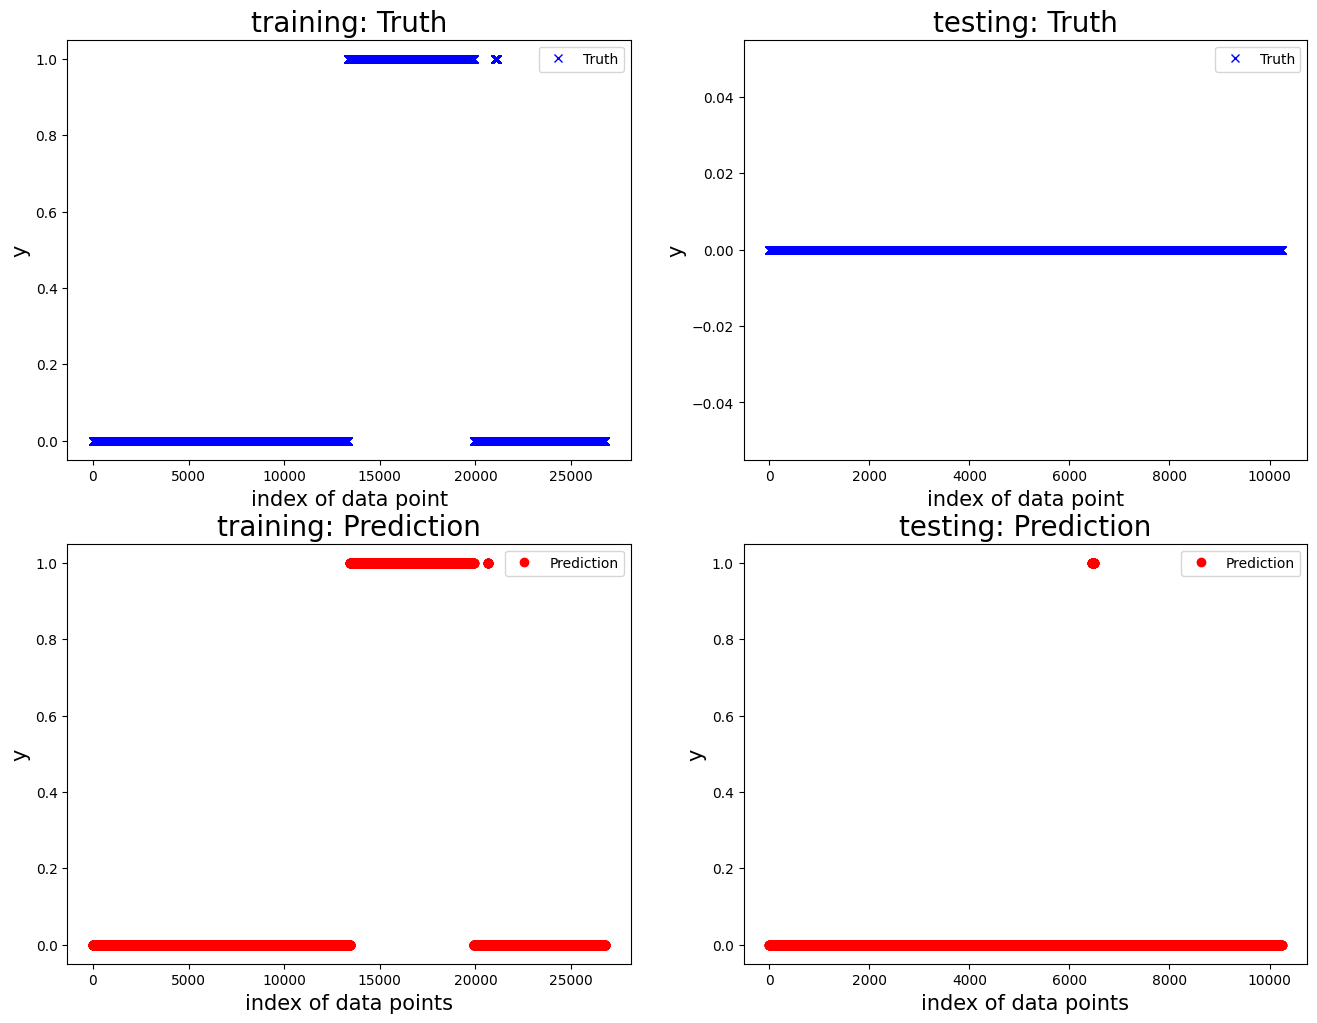


 New run:

training performance, accuracy is: 0.9949211908931699
training performance, precision is: 0.0
training performance, recall: 0.0
training performance, F1: 0.0



 New run:

testing performance, accuracy is: 0.7580142699226209
testing performance, precision is: 0.9785123966942149
testing performance, recall: 0.2710209064550588
testing performance, F1: 0.4244741873804972




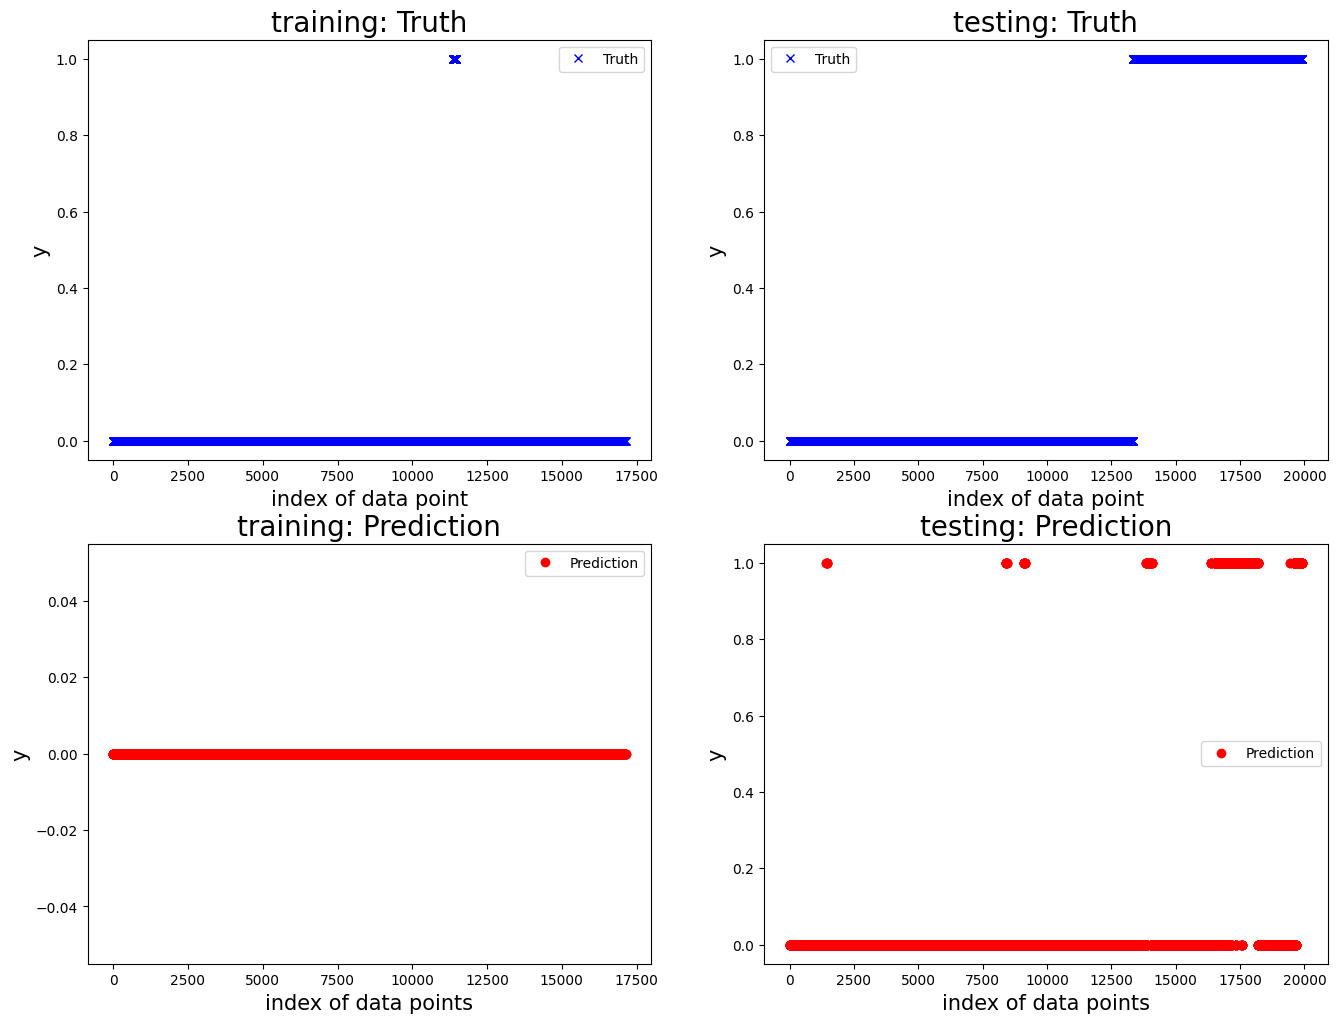


 New run:

training performance, accuracy is: 0.9995000735186002
training performance, precision is: 1.0
training performance, recall: 0.9974057683503739
training performance, F1: 0.9987011994804798



 New run:

testing performance, accuracy is: 0.9530888668648827
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




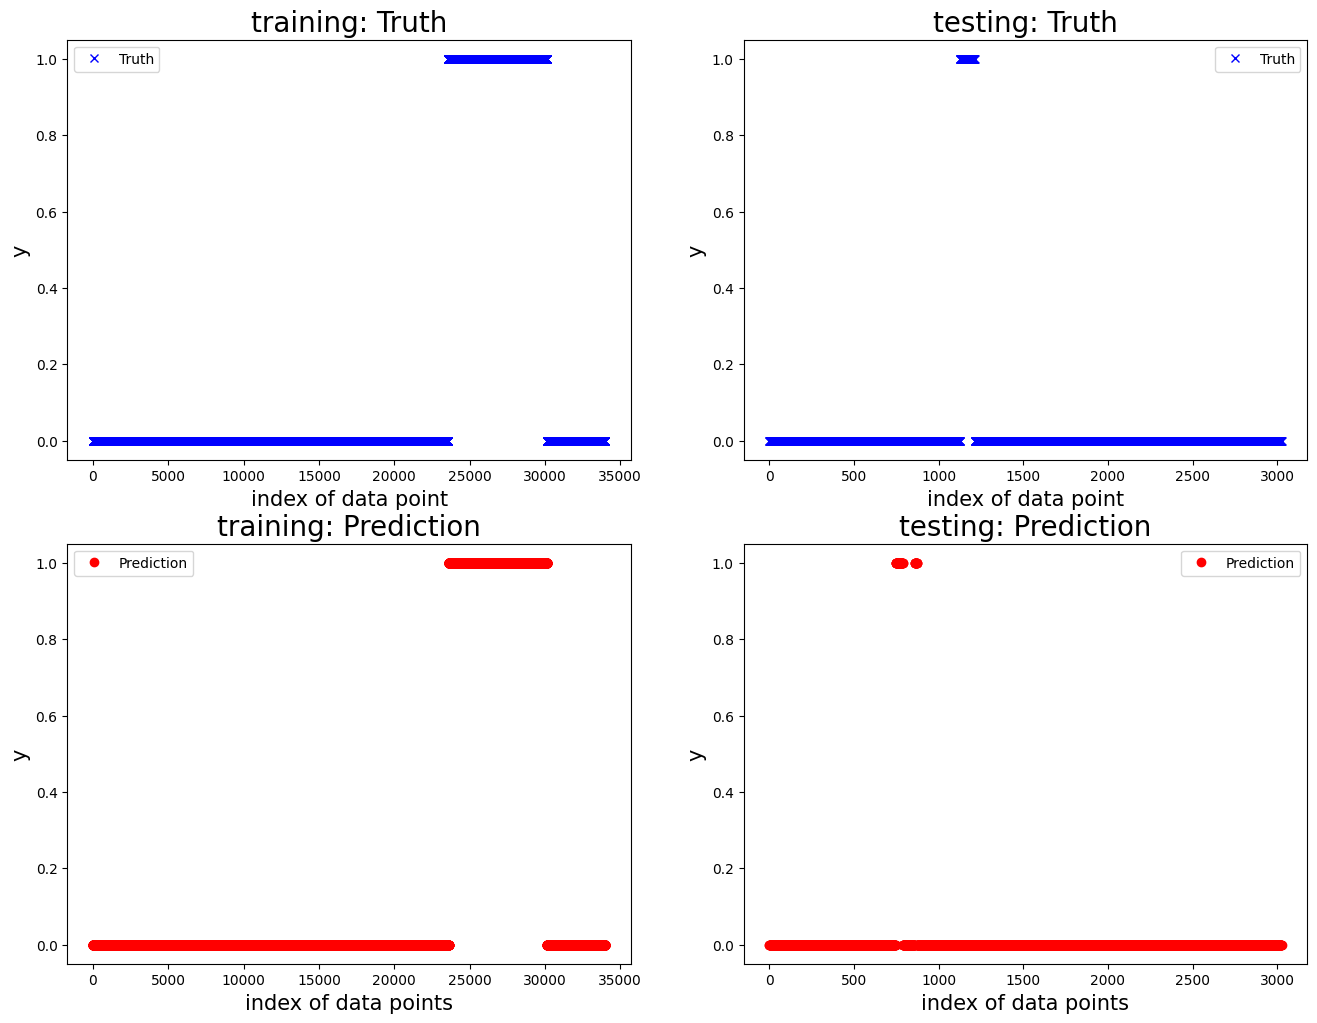


 New run:

training performance, accuracy is: 0.9943324250681199
training performance, precision is: 0.9981412639405205
training performance, recall: 0.9704819277108434
training performance, F1: 0.9841172877214417



 New run:

testing performance, accuracy is: 0.8554216867469879
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




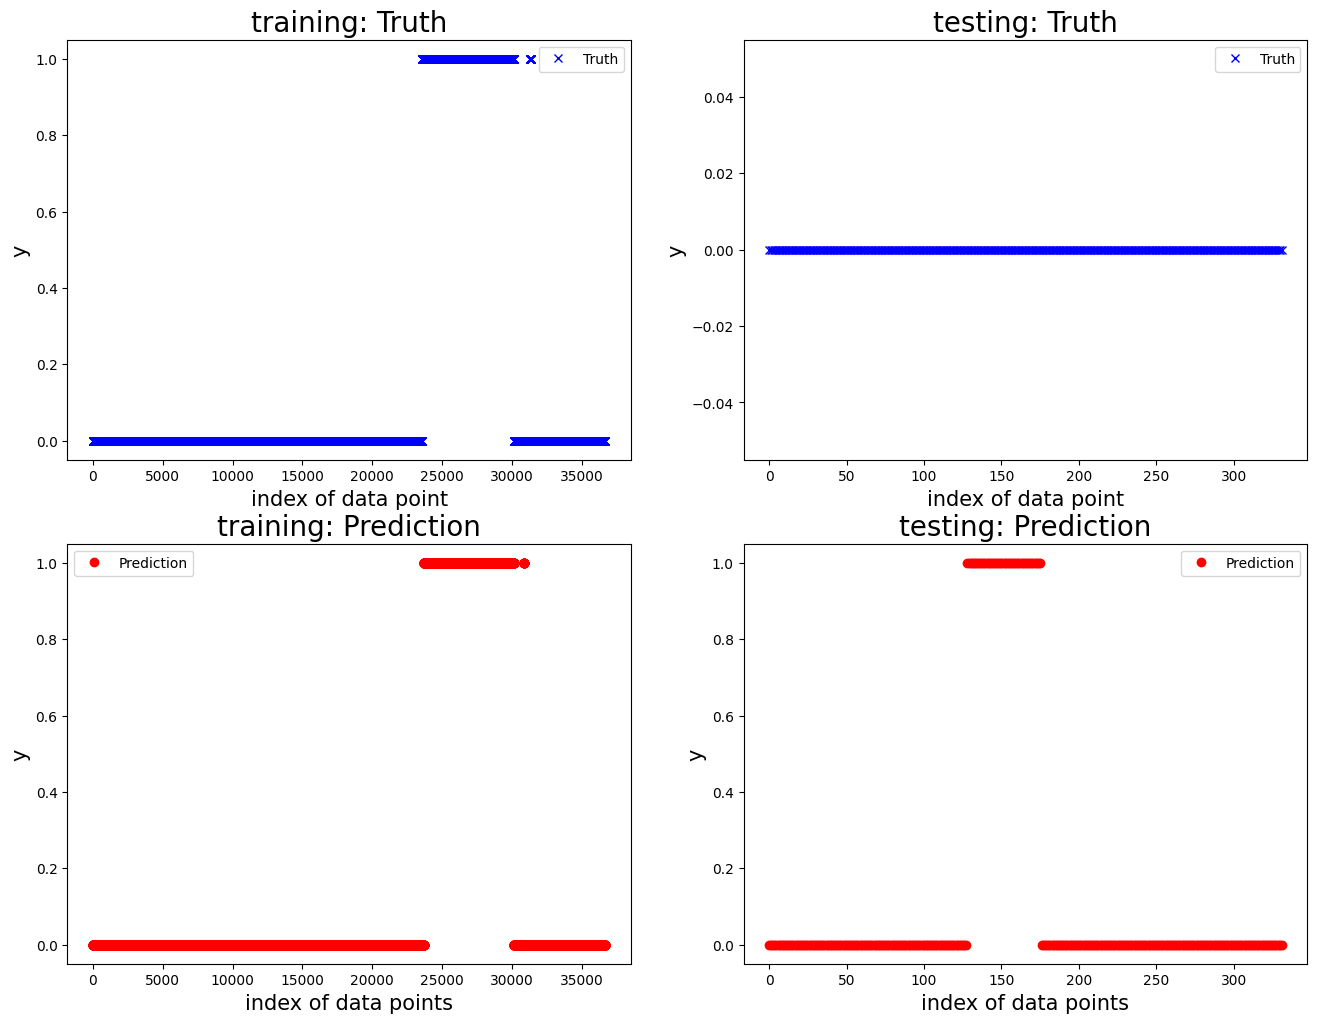


 New run:

training performance, accuracy is: 0.9941499522445081
training performance, precision is: 0.9976830398517146
training performance, recall: 0.9727409638554216
training performance, F1: 0.9850541406130852



 New run:

testing performance, accuracy is: 0.9767573696145124
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




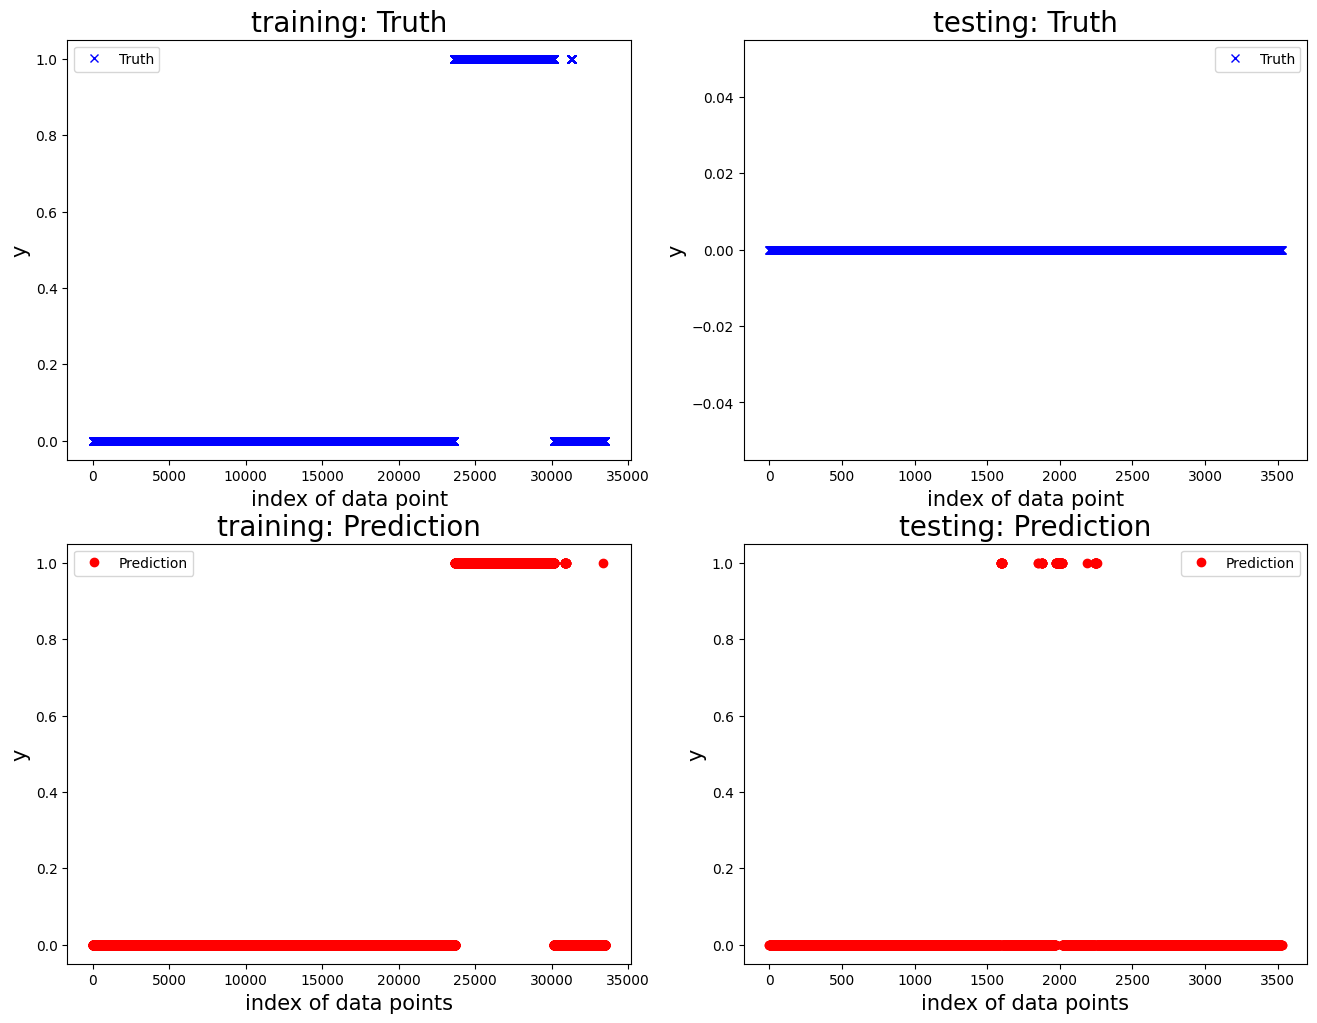

   Accuracy  Precision    Recall  F1 score
0  0.995412   0.000000  0.000000  0.000000
1  0.758014   0.978512  0.271021  0.424474
2  0.953089   0.000000  0.000000  0.000000
3  0.855422   0.000000  0.000000  0.000000
4  0.976757   0.000000  0.000000  0.000000


Mean performance metric and standard error:
Accuracy: 0.9077 +- 0.0996
Precision: 0.1957 +- 0.4376
Recall: 0.0542 +- 0.1212
F1 score: 0.0849 +- 0.1898




In [47]:
from utility import extract_selected_feature, prepare_sliding_window, run_cv_one_motor
from sklearn.linear_model import LogisticRegression

# Define the motor index.
motor_idx = 4

# Specify the test conditions you would like to include in the training.
df_data_experiment = df_train[df_train['test_condition'].isin(not_moving_train + pickup_and_place_train + moving_motor_mixed_train)]

# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

feature_list_custom = ['data_motor_1_temperature', 'data_motor_2_temperature','data_motor_2_temperature',
                       'data_motor_6_temperature', 'data_motor_6_voltage']

# Extract the features.
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_all, motor_idx, mdl_type='clf')

# Prepare the training data based on the defined sliding window.
window_size = 
sample_step = 1
X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression() )   # Step 2: Linear Regression
]

# Create the pipeline
model = Pipeline(steps)

# # Define hyperparameters to search
# param_grid = {
#     'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)
# mdl = grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)


all_result = run_cv_one_motor(single_run_result=True, motor_idx=motor_idx,  window_size=window_size, sample_step=sample_step,
                              df_data=df_data_experiment, mdl=model, 
                              feature_list=feature_list_custom, n_fold=5)
# Train the model.
# mdl = grid_search.fit(X_train, y_train)

### Prediction.

In this section, put the code of prediction here. In the end, please output a variable `y_pred_6`, containing the results of the prediction on motor 1.

In [ ]:
# Prepare for the testing dataset.
# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
# Add test_condition for extracting different sequences.
feature_list_all.append('test_condition')
# Get the features.
df_test_x = df_test[feature_list_all]
# Augument the features in the same way as the training data.
X_test = prepare_sliding_window(df_x=df_test_x, window_size=window_size, sample_step=sample_step, mdl_type='clf')
# Make prediction.
y_pred_6 = grid_search.predict(X_test)

TypeError: prepare_sliding_window() missing 1 required positional argument: 'y'

## Prepare the results as a submission file for the data challenge.

In this section, we demo how to prepare the results as a submission file for the data challenge. First, we need to download the submission template `sample_submission.csv` from [kaggle](https://www.kaggle.com/competitions/robot-predictive-maintenance/data). As shown below, in this csv files, we just need to give our prediction on the six motors in the corresponding columns. You can find a demo below.

In [ ]:
import pandas as pd

# Read the template.
path = 'kaggle_data_challenge/sample_submission.csv' # Change to your path.
df_submission = pd.read_csv(path)

# Initial all values with -1.
df_submission.loc[:, ['data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label', 'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label']] = -1
df_submission.head()

,idx,data_motor_1_label,data_motor_2_label,data_motor_3_label,data_motor_4_label,data_motor_5_label,data_motor_6_label,test_condition
0,0,-1,-1,-1,-1,-1,-1,20240527_094865
1,1,-1,-1,-1,-1,-1,-1,20240527_094865
2,2,-1,-1,-1,-1,-1,-1,20240527_094865
3,3,-1,-1,-1,-1,-1,-1,20240527_094865
4,4,-1,-1,-1,-1,-1,-1,20240527_094865


In [ ]:
# Replace each column with your prediction.
df_submission['data_motor_5_label'] = y_pred_5
df_submission['data_motor_6_label'] = y_pred_6

# For the other motors, we just fill with 0.
df_submission.loc[:, ['data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label', 'data_motor_4_label']] = 0

In [ ]:
# Output the submission csv.
df_submission.to_csv('../ws_prepare_data_challenge/submission.csv')